# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.sim import copy_diagnostics
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

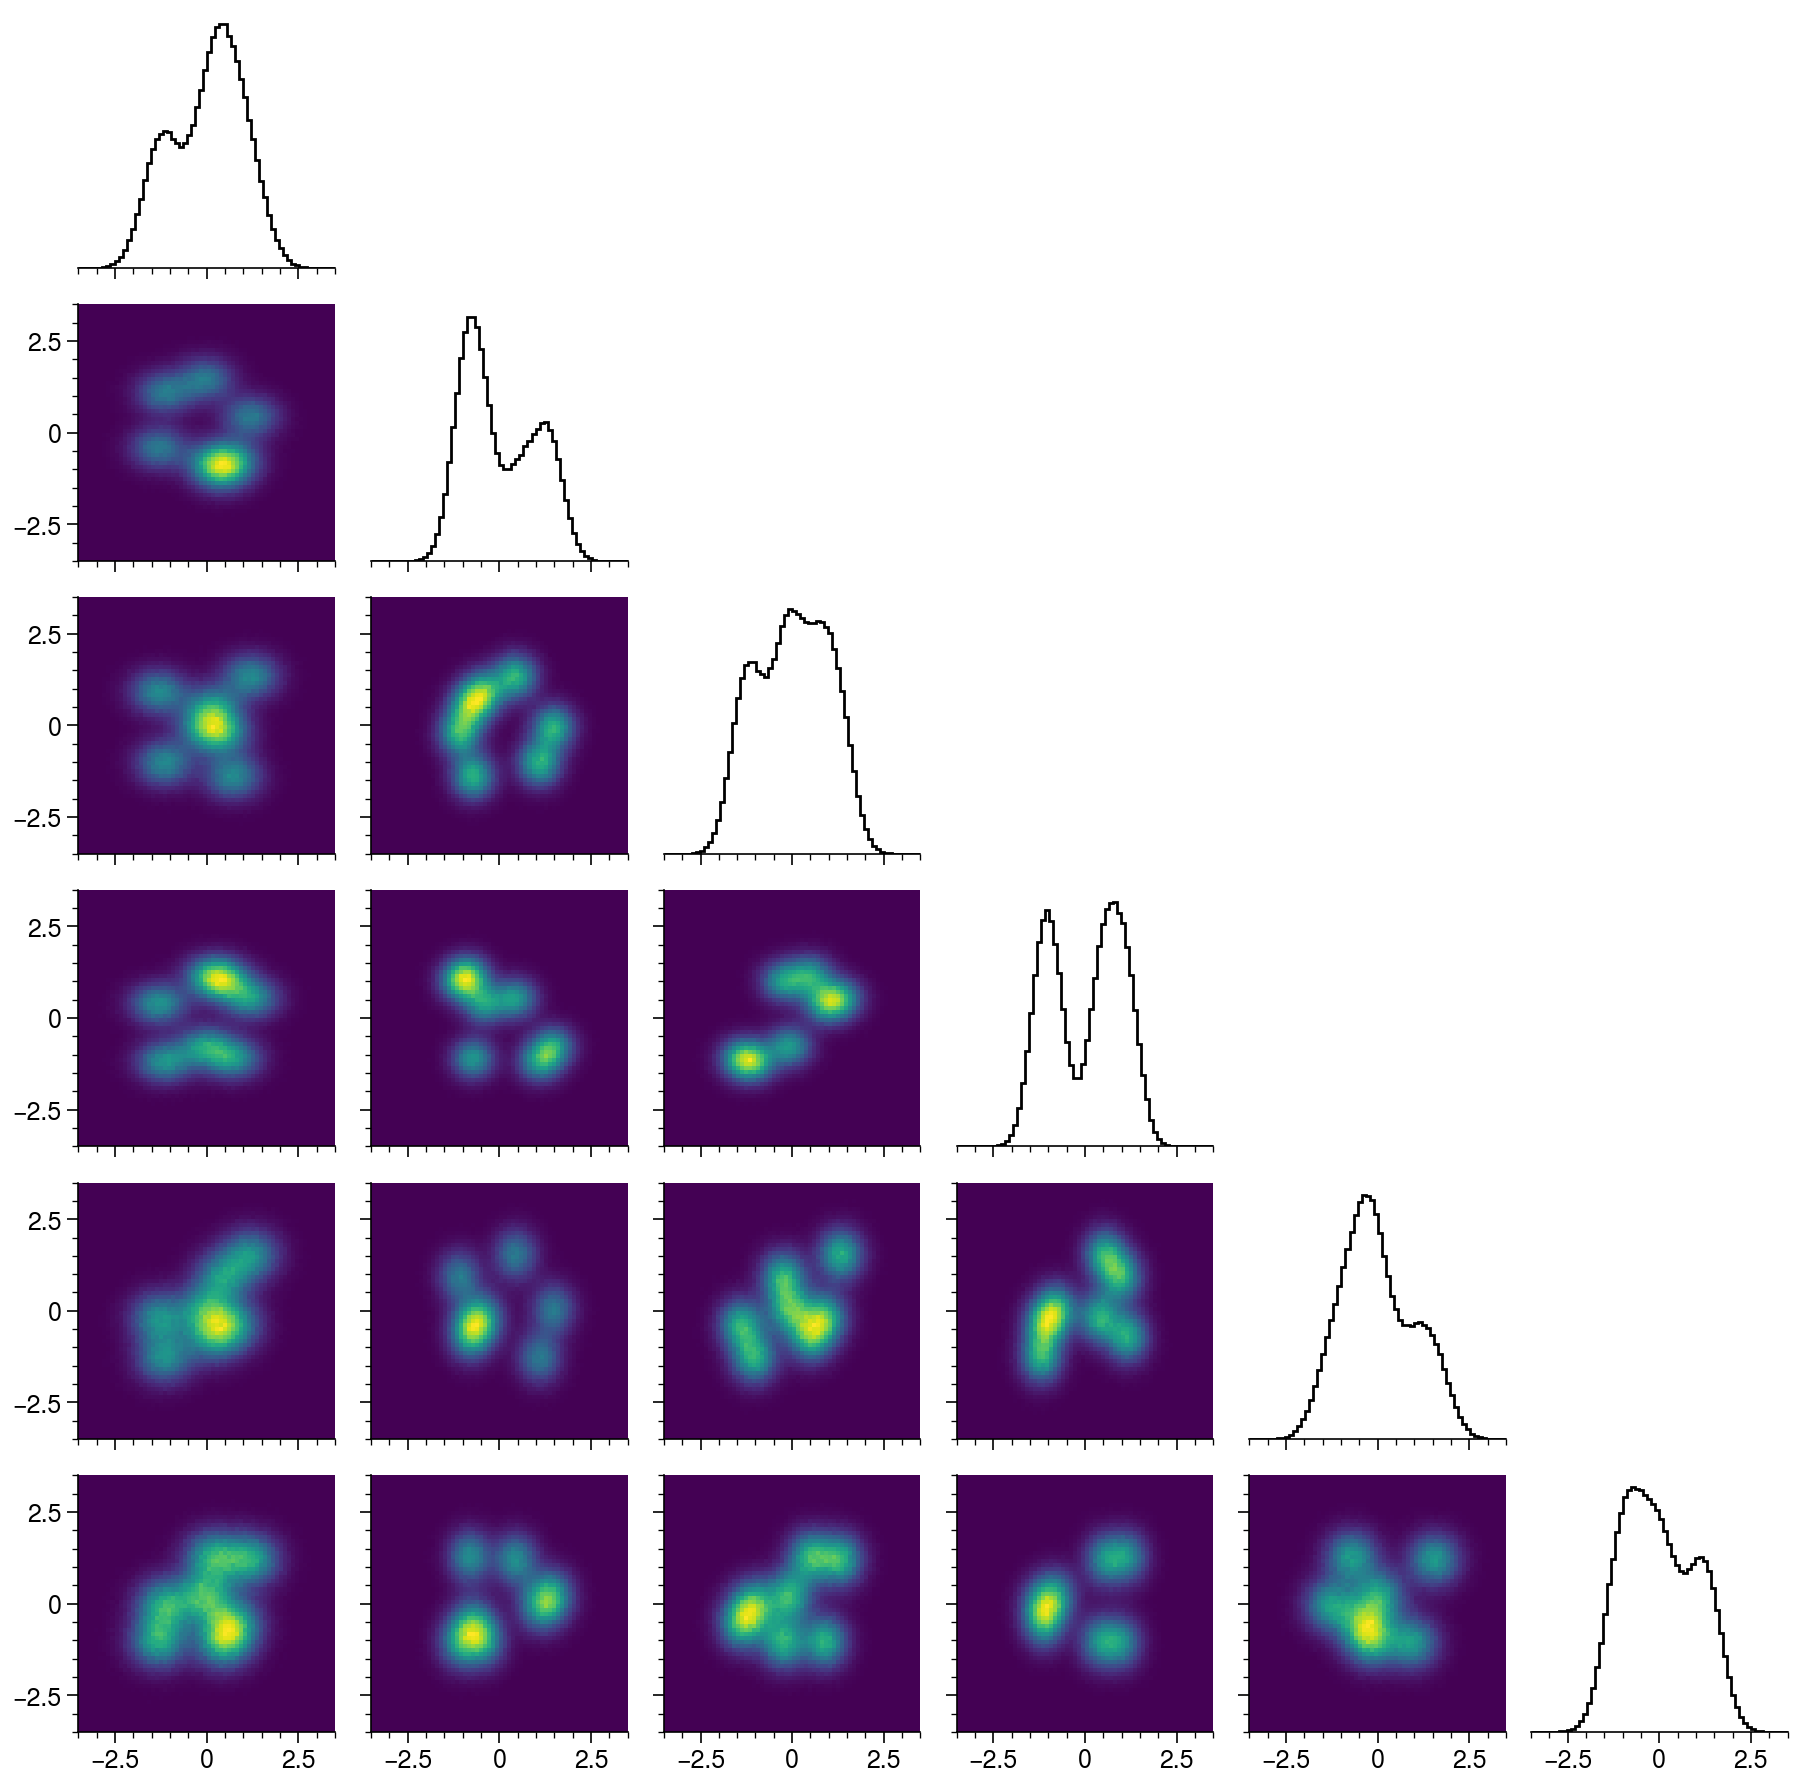

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
# Settings
nbins = 40
nmeas = ndim
kde = False
kde_bandwidth_frac = 1.0

## Measure 1D marginals
rng = np.random.default_rng(seed)
axis_meas = 0
n_meas = ndim

# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    j = axis_meas
    matrix = np.identity(ndim)
    matrix[i, i] = matrix[j, j] = 0.0
    matrix[i, j] = matrix[j, i] = 1.0
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth_frac=kde_bandwidth_frac
    )
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [7]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [8]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=True,
)

## Train

In [9]:
plot_nsamp = 1_000_000
plot_nbins = 64

In [10]:
plot_model = ment.train.Plotter(
    n_samples=plot_nsamp,
    plot_proj=[
        PlotProj1D(log=False),
        PlotProj1D(log=True),
    ],
    plot_dist=[
        PlotDistCorner(
            fig_kws=dict(figwidth=(ndim * 1.25), diag_shrink=0.80),
            limits=(ndim * [(-xmax, xmax)]),
            bins=plot_nbins,
        ),
    ],
)

eval_model = ment.train.Evaluator(n_samples=plot_nsamp)

non numeric history values being saved


  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 401/14031 [00:00<00:03, 4005.15it/s]

  6%|██████▎                                                                                                       | 811/14031 [00:00<00:03, 4060.49it/s]

  9%|█████████▍                                                                                                   | 1222/14031 [00:00<00:03, 4081.04it/s]

 12%|████████████▋                                                                                                | 1635/14031 [00:00<00:03, 4098.59it/s]

 15%|███████████████▉                                                                                             | 2046/14031 [00:00<00:02, 4100.50it/s]

 18%|███████████████████                                                                                          | 2457/14031 [00:00<00:02, 4103.36it/s]

 20%|██████████████████████▎                                                                                      | 2868/14031 [00:00<00:02, 4105.36it/s]

 23%|█████████████████████████▍                                                                                   | 3281/14031 [00:00<00:02, 4112.09it/s]

 26%|████████████████████████████▋                                                                                | 3693/14031 [00:00<00:02, 4113.97it/s]

 29%|███████████████████████████████▉                                                                             | 4106/14031 [00:01<00:02, 4116.34it/s]

 32%|███████████████████████████████████                                                                          | 4520/14031 [00:01<00:02, 4120.73it/s]

 35%|██████████████████████████████████████▎                                                                      | 4933/14031 [00:01<00:02, 4120.20it/s]

 38%|█████████████████████████████████████████▌                                                                   | 5346/14031 [00:01<00:02, 4122.41it/s]

 41%|████████████████████████████████████████████▋                                                                | 5760/14031 [00:01<00:02, 4124.96it/s]

 44%|███████████████████████████████████████████████▉                                                             | 6173/14031 [00:01<00:01, 4126.39it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 6586/14031 [00:01<00:01, 4114.47it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 6998/14031 [00:01<00:01, 4103.84it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 7413/14031 [00:01<00:01, 4116.84it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 7827/14031 [00:01<00:01, 4121.80it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 8241/14031 [00:02<00:01, 4125.99it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 8656/14031 [00:02<00:01, 4130.21it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 9070/14031 [00:02<00:01, 4109.06it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 9481/14031 [00:02<00:01, 4075.50it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 9889/14031 [00:02<00:01, 4034.31it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 10293/14031 [00:02<00:00, 4022.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 10709/14031 [00:02<00:00, 4062.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 11126/14031 [00:02<00:00, 4091.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 11541/14031 [00:02<00:00, 4106.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 11952/14031 [00:02<00:00, 4096.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 12366/14031 [00:03<00:00, 4106.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 12777/14031 [00:03<00:00, 4093.17it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 13187/14031 [00:03<00:00, 4088.01it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 13602/14031 [00:03<00:00, 4105.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 14017/14031 [00:03<00:00, 4117.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4100.77it/s]

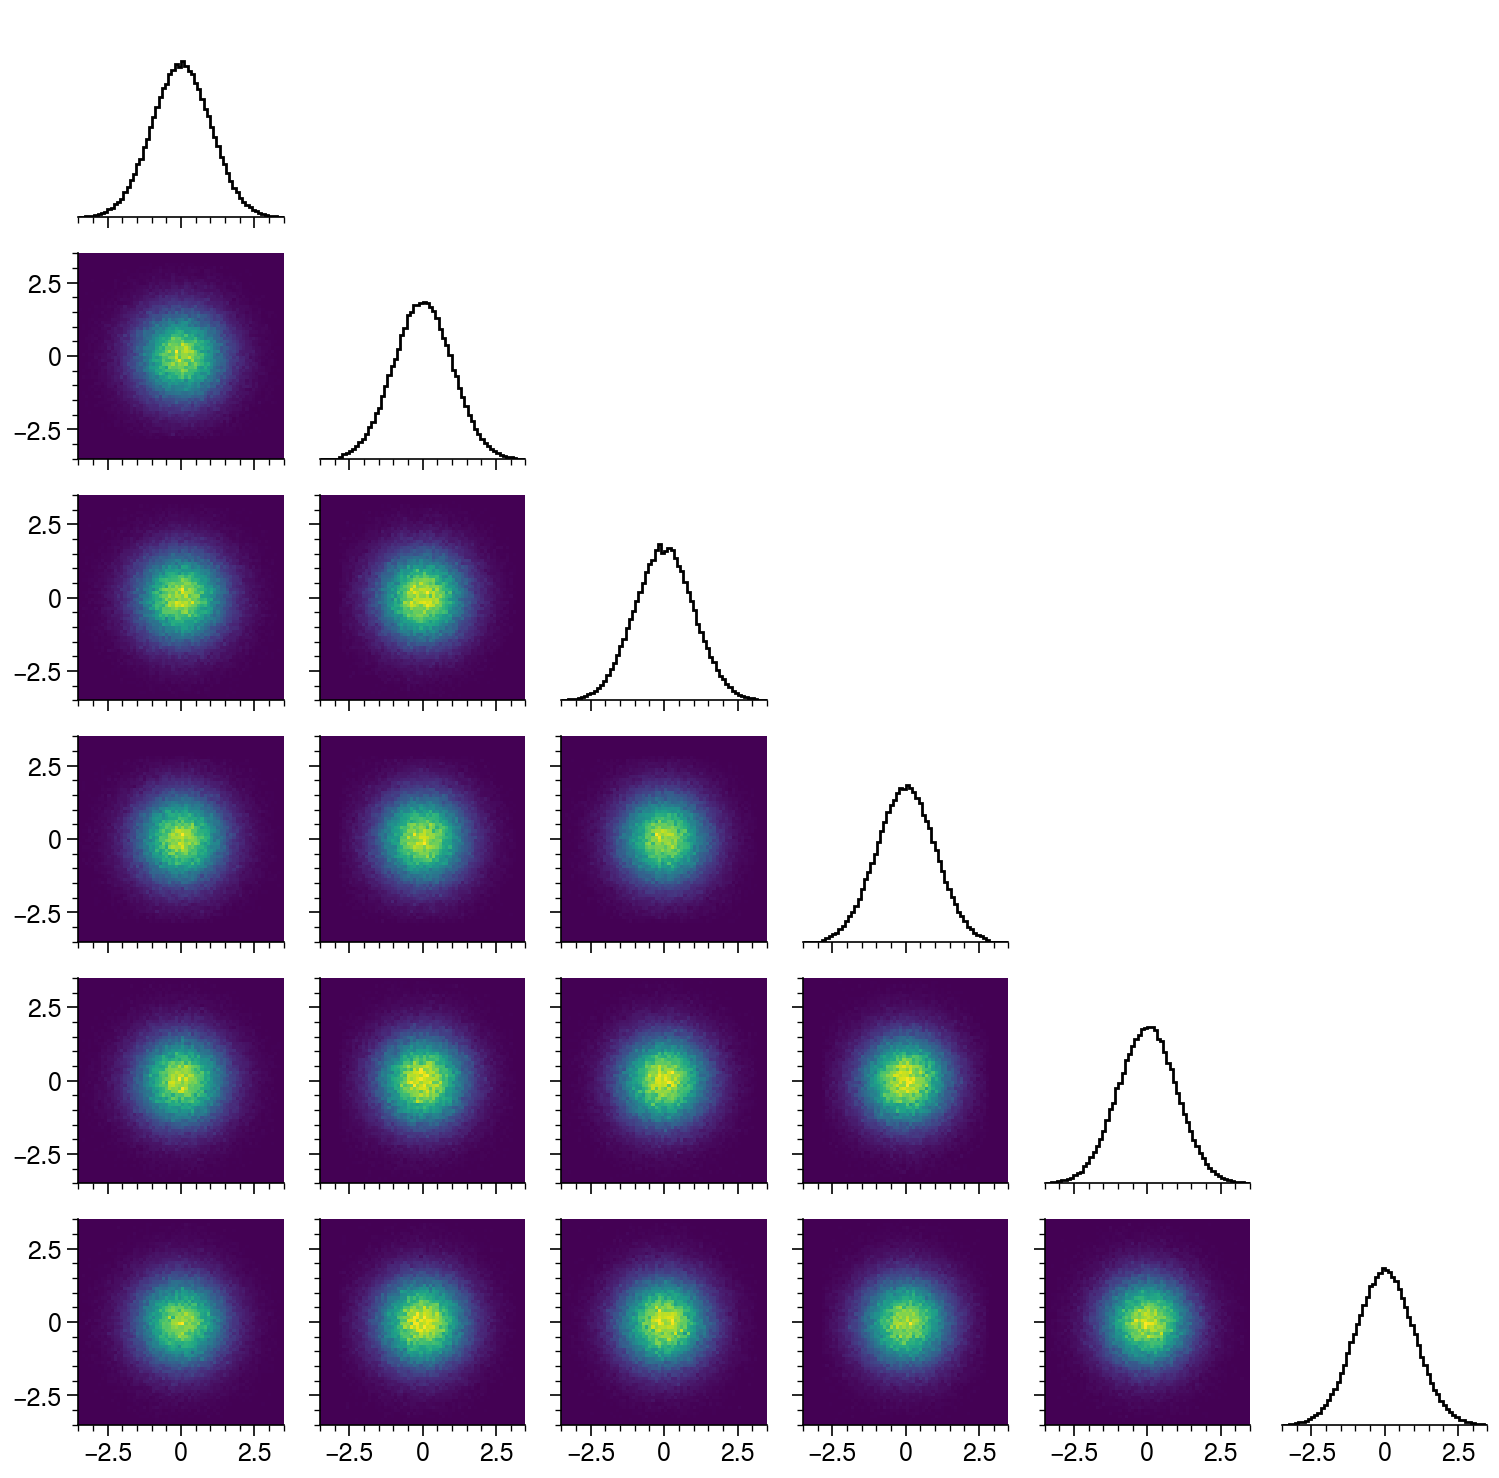

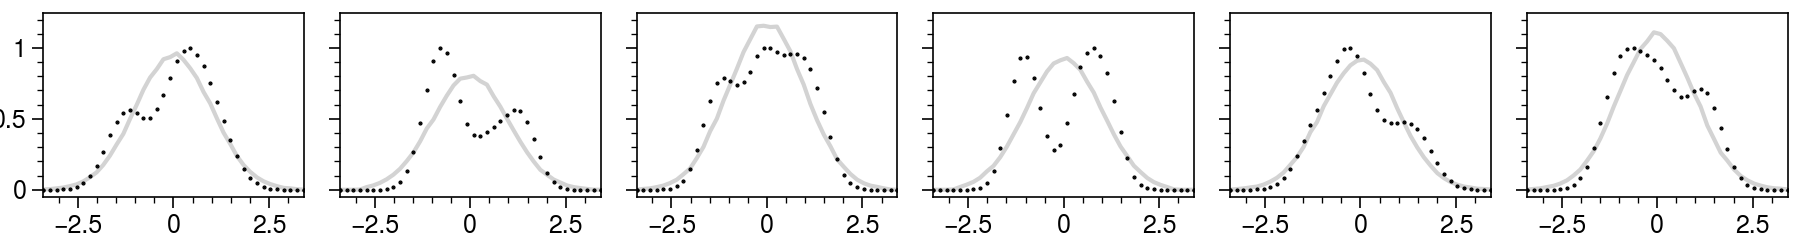

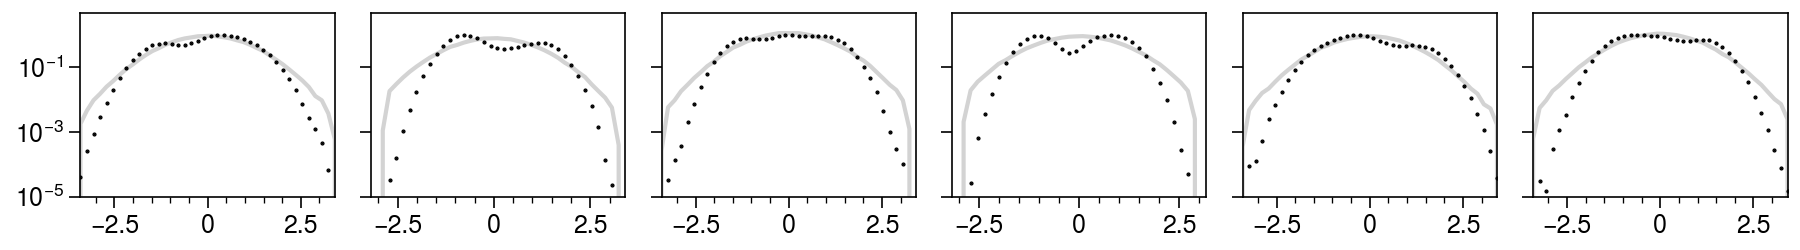

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 412/14031 [00:00<00:03, 4112.85it/s]

  6%|██████▍                                                                                                       | 829/14031 [00:00<00:03, 4145.79it/s]

  9%|█████████▋                                                                                                   | 1244/14031 [00:00<00:03, 4143.04it/s]

 12%|████████████▉                                                                                                | 1659/14031 [00:00<00:03, 4113.66it/s]

 15%|████████████████                                                                                             | 2071/14031 [00:00<00:02, 4105.57it/s]

 18%|███████████████████▎                                                                                         | 2489/14031 [00:00<00:02, 4129.15it/s]

 21%|██████████████████████▌                                                                                      | 2905/14031 [00:00<00:02, 4137.00it/s]

 24%|█████████████████████████▊                                                                                   | 3322/14031 [00:00<00:02, 4146.32it/s]

 27%|█████████████████████████████                                                                                | 3738/14031 [00:00<00:02, 4149.44it/s]

 30%|████████████████████████████████▎                                                                            | 4155/14031 [00:01<00:02, 4154.03it/s]

 33%|███████████████████████████████████▌                                                                         | 4571/14031 [00:01<00:02, 4155.30it/s]

 36%|██████████████████████████████████████▋                                                                      | 4987/14031 [00:01<00:02, 4152.24it/s]

 39%|█████████████████████████████████████████▉                                                                   | 5403/14031 [00:01<00:02, 4151.40it/s]

 41%|█████████████████████████████████████████████▏                                                               | 5819/14031 [00:01<00:01, 4127.54it/s]

 44%|████████████████████████████████████████████████▍                                                            | 6237/14031 [00:01<00:01, 4141.29it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 6652/14031 [00:01<00:01, 4141.51it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 7070/14031 [00:01<00:01, 4152.18it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 7488/14031 [00:01<00:01, 4159.61it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 7906/14031 [00:01<00:01, 4163.12it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 8324/14031 [00:02<00:01, 4165.90it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 8741/14031 [00:02<00:01, 4158.56it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 9157/14031 [00:02<00:01, 4140.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 9572/14031 [00:02<00:01, 4139.76it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 9988/14031 [00:02<00:00, 4145.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 10404/14031 [00:02<00:00, 4148.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 10819/14031 [00:02<00:00, 4147.77it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 11235/14031 [00:02<00:00, 4149.59it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 11652/14031 [00:02<00:00, 4154.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 12069/14031 [00:02<00:00, 4157.06it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 12485/14031 [00:03<00:00, 4156.71it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 12903/14031 [00:03<00:00, 4161.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 13320/14031 [00:03<00:00, 4161.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 13738/14031 [00:03<00:00, 4164.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4148.62it/s]

{'mean_abs_error': 0.043739188911816586}
epoch = 1
transform=0
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▊                                                                                                          | 415/12015 [00:00<00:02, 4145.39it/s]

  7%|███████▌                                                                                                      | 831/12015 [00:00<00:02, 4152.11it/s]

 10%|███████████▎                                                                                                 | 1248/12015 [00:00<00:02, 4159.63it/s]

 14%|███████████████                                                                                              | 1664/12015 [00:00<00:02, 4151.42it/s]

 17%|██████████████████▊                                                                                          | 2080/12015 [00:00<00:02, 4135.73it/s]

 21%|██████████████████████▋                                                                                      | 2494/12015 [00:00<00:02, 4133.62it/s]

 24%|██████████████████████████▍                                                                                  | 2911/12015 [00:00<00:02, 4144.39it/s]

 28%|██████████████████████████████▏                                                                              | 3327/12015 [00:00<00:02, 4146.25it/s]

 31%|█████████████████████████████████▉                                                                           | 3742/12015 [00:00<00:01, 4141.77it/s]

 35%|█████████████████████████████████████▋                                                                       | 4157/12015 [00:01<00:01, 4141.64it/s]

 38%|█████████████████████████████████████████▍                                                                   | 4572/12015 [00:01<00:01, 4138.40it/s]

 42%|█████████████████████████████████████████████▎                                                               | 4988/12015 [00:01<00:01, 4143.04it/s]

 45%|█████████████████████████████████████████████████                                                            | 5403/12015 [00:01<00:01, 4136.74it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 5817/12015 [00:01<00:01, 4135.84it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 6233/12015 [00:01<00:01, 4141.95it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 6649/12015 [00:01<00:01, 4144.72it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 7064/12015 [00:01<00:01, 4139.81it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 7480/12015 [00:01<00:01, 4143.16it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 7895/12015 [00:01<00:00, 4121.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 8309/12015 [00:02<00:00, 4126.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 8727/12015 [00:02<00:00, 4141.54it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 9142/12015 [00:02<00:00, 4135.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 9556/12015 [00:02<00:00, 4077.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 9966/12015 [00:02<00:00, 4083.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 10375/12015 [00:02<00:00, 4072.47it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 10783/12015 [00:02<00:00, 4069.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11192/12015 [00:02<00:00, 4075.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 11600/12015 [00:02<00:00, 4056.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 12006/12015 [00:02<00:00, 4020.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4110.80it/s]

transform=1
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 400/12015 [00:00<00:02, 3996.81it/s]

  7%|███████▎                                                                                                      | 800/12015 [00:00<00:02, 3990.80it/s]

 10%|███████████                                                                                                  | 1214/12015 [00:00<00:02, 4055.34it/s]

 14%|██████████████▊                                                                                              | 1629/12015 [00:00<00:02, 4089.91it/s]

 17%|██████████████████▌                                                                                          | 2043/12015 [00:00<00:02, 4107.52it/s]

 20%|██████████████████████▎                                                                                      | 2457/12015 [00:00<00:02, 4116.55it/s]

 24%|██████████████████████████                                                                                   | 2872/12015 [00:00<00:02, 4126.34it/s]

 27%|█████████████████████████████▊                                                                               | 3287/12015 [00:00<00:02, 4132.75it/s]

 31%|█████████████████████████████████▌                                                                           | 3702/12015 [00:00<00:02, 4137.17it/s]

 34%|█████████████████████████████████████▎                                                                       | 4118/12015 [00:01<00:01, 4141.90it/s]

 38%|█████████████████████████████████████████                                                                    | 4533/12015 [00:01<00:01, 4141.11it/s]

 41%|████████████████████████████████████████████▉                                                                | 4948/12015 [00:01<00:01, 4139.67it/s]

 45%|████████████████████████████████████████████████▋                                                            | 5362/12015 [00:01<00:01, 4130.55it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 5776/12015 [00:01<00:01, 4118.47it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 6188/12015 [00:01<00:01, 4091.18it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6598/12015 [00:01<00:01, 4056.75it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7004/12015 [00:01<00:01, 4038.18it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7418/12015 [00:01<00:01, 4067.89it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 7833/12015 [00:01<00:01, 4090.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8243/12015 [00:02<00:00, 4079.75it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 8655/12015 [00:02<00:00, 4090.25it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 9065/12015 [00:02<00:00, 4076.62it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 9479/12015 [00:02<00:00, 4091.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 9889/12015 [00:02<00:00, 4006.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 10291/12015 [00:02<00:00, 3986.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 10704/12015 [00:02<00:00, 4026.32it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11111/12015 [00:02<00:00, 4037.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11518/12015 [00:02<00:00, 4044.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 11930/12015 [00:02<00:00, 4066.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4079.13it/s]

transform=2
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 407/12015 [00:00<00:02, 4061.18it/s]

  7%|███████▍                                                                                                      | 819/12015 [00:00<00:02, 4092.43it/s]

 10%|███████████▏                                                                                                 | 1233/12015 [00:00<00:02, 4113.03it/s]

 14%|██████████████▉                                                                                              | 1645/12015 [00:00<00:02, 4082.98it/s]

 17%|██████████████████▋                                                                                          | 2056/12015 [00:00<00:02, 4089.43it/s]

 21%|██████████████████████▎                                                                                      | 2465/12015 [00:00<00:02, 4048.89it/s]

 24%|██████████████████████████                                                                                   | 2872/12015 [00:00<00:02, 4055.20it/s]

 27%|█████████████████████████████▊                                                                               | 3284/12015 [00:00<00:02, 4073.11it/s]

 31%|█████████████████████████████████▍                                                                           | 3692/12015 [00:00<00:02, 4070.48it/s]

 34%|█████████████████████████████████████▏                                                                       | 4104/12015 [00:01<00:01, 4083.58it/s]

 38%|████████████████████████████████████████▉                                                                    | 4513/12015 [00:01<00:01, 4081.99it/s]

 41%|████████████████████████████████████████████▋                                                                | 4922/12015 [00:01<00:01, 4068.36it/s]

 44%|████████████████████████████████████████████████▎                                                            | 5329/12015 [00:01<00:01, 4062.27it/s]

 48%|████████████████████████████████████████████████████                                                         | 5741/12015 [00:01<00:01, 4077.67it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 6149/12015 [00:01<00:01, 4037.35it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 6553/12015 [00:01<00:01, 4018.62it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 6962/12015 [00:01<00:01, 4038.43it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 7366/12015 [00:01<00:01, 4032.38it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 7770/12015 [00:01<00:01, 3987.80it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 8174/12015 [00:02<00:00, 4003.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 8580/12015 [00:02<00:00, 4019.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 8989/12015 [00:02<00:00, 4038.93it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 9399/12015 [00:02<00:00, 4056.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 9811/12015 [00:02<00:00, 4073.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 10219/12015 [00:02<00:00, 4071.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 10627/12015 [00:02<00:00, 4065.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11034/12015 [00:02<00:00, 4053.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 11447/12015 [00:02<00:00, 4074.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11860/12015 [00:02<00:00, 4088.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4055.44it/s]

transform=3
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▊                                                                                                          | 415/12015 [00:00<00:02, 4141.42it/s]

  7%|███████▌                                                                                                      | 830/12015 [00:00<00:02, 4141.62it/s]

 10%|███████████▎                                                                                                 | 1245/12015 [00:00<00:02, 4126.45it/s]

 14%|███████████████                                                                                              | 1658/12015 [00:00<00:02, 4124.16it/s]

 17%|██████████████████▊                                                                                          | 2071/12015 [00:00<00:02, 4124.04it/s]

 21%|██████████████████████▌                                                                                      | 2484/12015 [00:00<00:02, 4081.37it/s]

 24%|██████████████████████████▏                                                                                  | 2893/12015 [00:00<00:02, 4067.00it/s]

 28%|█████████████████████████████▉                                                                               | 3305/12015 [00:00<00:02, 4082.59it/s]

 31%|█████████████████████████████████▋                                                                           | 3720/12015 [00:00<00:02, 4100.82it/s]

 34%|█████████████████████████████████████▍                                                                       | 4131/12015 [00:01<00:01, 4093.70it/s]

 38%|█████████████████████████████████████████▏                                                                   | 4542/12015 [00:01<00:01, 4098.64it/s]

 41%|████████████████████████████████████████████▉                                                                | 4952/12015 [00:01<00:01, 4061.08it/s]

 45%|████████████████████████████████████████████████▋                                                            | 5362/12015 [00:01<00:01, 4071.55it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5772/12015 [00:01<00:01, 4079.79it/s]

 51%|████████████████████████████████████████████████████████                                                     | 6181/12015 [00:01<00:01, 4051.25it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6596/12015 [00:01<00:01, 4080.17it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7005/12015 [00:01<00:01, 4068.61it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 7412/12015 [00:01<00:01, 4062.75it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 7826/12015 [00:01<00:01, 4082.95it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 8235/12015 [00:02<00:00, 4080.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8644/12015 [00:02<00:00, 4070.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 9052/12015 [00:02<00:00, 4046.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 9463/12015 [00:02<00:00, 4063.74it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 9870/12015 [00:02<00:00, 4060.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 10282/12015 [00:02<00:00, 4076.37it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 10693/12015 [00:02<00:00, 4084.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11107/12015 [00:02<00:00, 4098.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11522/12015 [00:02<00:00, 4111.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11934/12015 [00:02<00:00, 4096.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4081.59it/s]

transform=4
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 405/12015 [00:00<00:02, 4044.83it/s]

  7%|███████▍                                                                                                      | 811/12015 [00:00<00:02, 4050.13it/s]

 10%|███████████                                                                                                  | 1223/12015 [00:00<00:02, 4081.09it/s]

 14%|██████████████▊                                                                                              | 1632/12015 [00:00<00:02, 4074.11it/s]

 17%|██████████████████▌                                                                                          | 2047/12015 [00:00<00:02, 4099.52it/s]

 20%|██████████████████████▎                                                                                      | 2462/12015 [00:00<00:02, 4116.07it/s]

 24%|██████████████████████████                                                                                   | 2875/12015 [00:00<00:02, 4119.26it/s]

 27%|█████████████████████████████▊                                                                               | 3289/12015 [00:00<00:02, 4125.25it/s]

 31%|█████████████████████████████████▌                                                                           | 3704/12015 [00:00<00:02, 4132.29it/s]

 34%|█████████████████████████████████████▍                                                                       | 4120/12015 [00:01<00:01, 4138.36it/s]

 38%|█████████████████████████████████████████▏                                                                   | 4534/12015 [00:01<00:01, 4138.40it/s]

 41%|████████████████████████████████████████████▉                                                                | 4951/12015 [00:01<00:01, 4145.12it/s]

 45%|████████████████████████████████████████████████▋                                                            | 5366/12015 [00:01<00:01, 4135.82it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 5780/12015 [00:01<00:01, 4125.81it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 6193/12015 [00:01<00:01, 4067.89it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 6604/12015 [00:01<00:01, 4077.96it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7012/12015 [00:01<00:01, 4078.26it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 7427/12015 [00:01<00:01, 4097.52it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 7842/12015 [00:01<00:01, 4111.37it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 8256/12015 [00:02<00:00, 4118.99it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 8673/12015 [00:02<00:00, 4132.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 9087/12015 [00:02<00:00, 4132.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 9501/12015 [00:02<00:00, 4134.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 9916/12015 [00:02<00:00, 4137.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 10330/12015 [00:02<00:00, 4137.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 10744/12015 [00:02<00:00, 4137.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11158/12015 [00:02<00:00, 4128.11it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 11571/12015 [00:02<00:00, 4114.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 11989/12015 [00:02<00:00, 4131.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4116.20it/s]

transform=5
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 407/12015 [00:00<00:02, 4062.41it/s]

  7%|███████▌                                                                                                      | 821/12015 [00:00<00:02, 4103.65it/s]

 10%|███████████▏                                                                                                 | 1236/12015 [00:00<00:02, 4123.69it/s]

 14%|██████████████▉                                                                                              | 1650/12015 [00:00<00:02, 4126.65it/s]

 17%|██████████████████▋                                                                                          | 2063/12015 [00:00<00:02, 4114.95it/s]

 21%|██████████████████████▍                                                                                      | 2475/12015 [00:00<00:02, 4093.38it/s]

 24%|██████████████████████████▏                                                                                  | 2885/12015 [00:00<00:02, 4075.78it/s]

 27%|█████████████████████████████▉                                                                               | 3298/12015 [00:00<00:02, 4092.31it/s]

 31%|█████████████████████████████████▋                                                                           | 3710/12015 [00:00<00:02, 4098.09it/s]

 34%|█████████████████████████████████████▍                                                                       | 4120/12015 [00:01<00:01, 4097.18it/s]

 38%|█████████████████████████████████████████                                                                    | 4532/12015 [00:01<00:01, 4102.63it/s]

 41%|████████████████████████████████████████████▊                                                                | 4943/12015 [00:01<00:01, 4063.70it/s]

 45%|████████████████████████████████████████████████▌                                                            | 5354/12015 [00:01<00:01, 4077.50it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5769/12015 [00:01<00:01, 4096.36it/s]

 51%|████████████████████████████████████████████████████████                                                     | 6181/12015 [00:01<00:01, 4100.78it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6592/12015 [00:01<00:01, 4099.18it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7002/12015 [00:01<00:01, 4078.48it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 7410/12015 [00:01<00:01, 4065.73it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 7817/12015 [00:01<00:01, 4059.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8225/12015 [00:02<00:00, 4063.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 8632/12015 [00:02<00:00, 4043.71it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 9044/12015 [00:02<00:00, 4065.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 9459/12015 [00:02<00:00, 4090.09it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 9870/12015 [00:02<00:00, 4095.37it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 10280/12015 [00:02<00:00, 4060.76it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 10695/12015 [00:02<00:00, 4086.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11104/12015 [00:02<00:00, 4074.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11516/12015 [00:02<00:00, 4086.07it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 11925/12015 [00:02<00:00, 4074.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4082.93it/s]

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 412/14031 [00:00<00:03, 4111.86it/s]

  6%|██████▍                                                                                                       | 824/14031 [00:00<00:03, 4112.54it/s]

  9%|█████████▌                                                                                                   | 1236/14031 [00:00<00:03, 4091.10it/s]

 12%|████████████▊                                                                                                | 1647/14031 [00:00<00:03, 4096.58it/s]

 15%|███████████████▉                                                                                             | 2058/14031 [00:00<00:02, 4099.28it/s]

 18%|███████████████████▏                                                                                         | 2469/14031 [00:00<00:02, 4102.58it/s]

 21%|██████████████████████▎                                                                                      | 2880/14031 [00:00<00:02, 4100.79it/s]

 23%|█████████████████████████▌                                                                                   | 3291/14031 [00:00<00:02, 4101.45it/s]

 26%|████████████████████████████▊                                                                                | 3707/14031 [00:00<00:02, 4118.27it/s]

 29%|████████████████████████████████                                                                             | 4122/14031 [00:01<00:02, 4126.92it/s]

 32%|███████████████████████████████████▏                                                                         | 4537/14031 [00:01<00:02, 4133.08it/s]

 35%|██████████████████████████████████████▍                                                                      | 4952/14031 [00:01<00:02, 4135.68it/s]

 38%|█████████████████████████████████████████▋                                                                   | 5367/14031 [00:01<00:02, 4137.94it/s]

 41%|████████████████████████████████████████████▉                                                                | 5783/14031 [00:01<00:01, 4141.63it/s]

 44%|████████████████████████████████████████████████▏                                                            | 6198/14031 [00:01<00:01, 4142.78it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 6613/14031 [00:01<00:01, 4143.52it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 7028/14031 [00:01<00:01, 4140.14it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 7443/14031 [00:01<00:01, 4134.84it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 7857/14031 [00:01<00:01, 4126.03it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 8273/14031 [00:02<00:01, 4133.37it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 8689/14031 [00:02<00:01, 4139.32it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 9105/14031 [00:02<00:01, 4143.43it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 9521/14031 [00:02<00:01, 4145.71it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 9936/14031 [00:02<00:00, 4145.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 10352/14031 [00:02<00:00, 4147.90it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 10767/14031 [00:02<00:00, 4141.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 11182/14031 [00:02<00:00, 4143.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 11597/14031 [00:02<00:00, 4136.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 12011/14031 [00:02<00:00, 4134.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 12425/14031 [00:03<00:00, 4126.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 12838/14031 [00:03<00:00, 4121.74it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 13251/14031 [00:03<00:00, 4119.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 13666/14031 [00:03<00:00, 4127.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4128.17it/s]

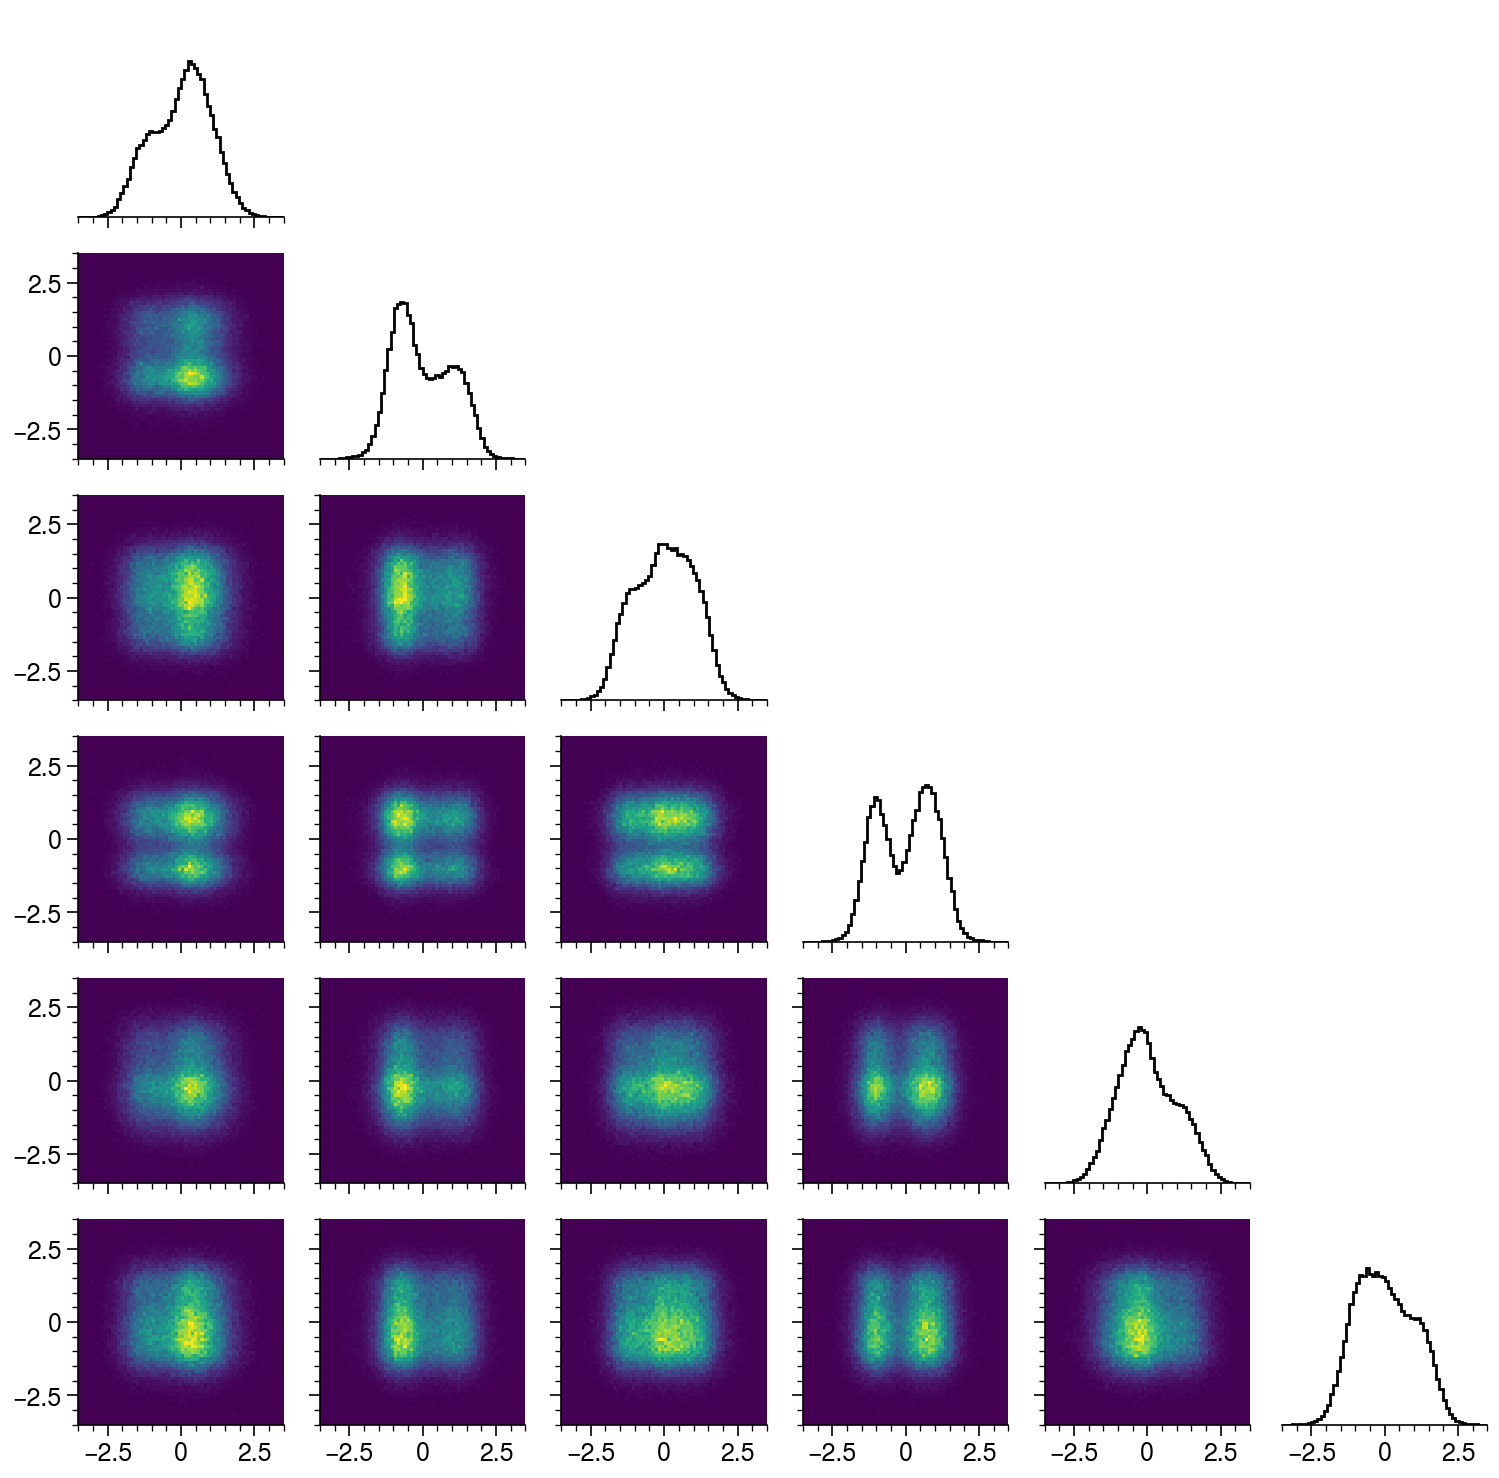

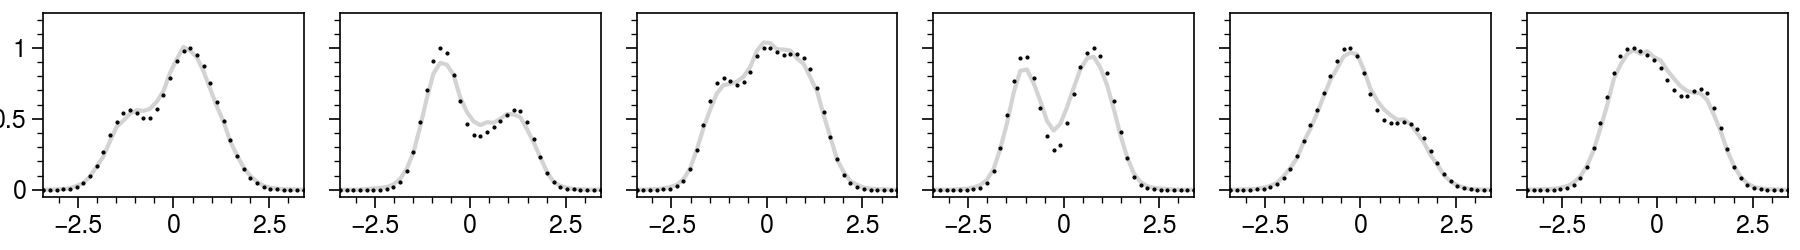

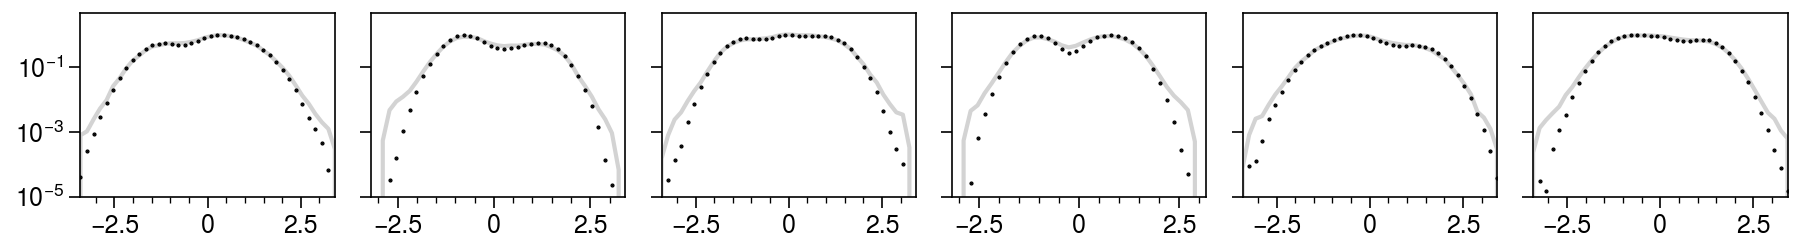

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 406/14031 [00:00<00:03, 4058.58it/s]

  6%|██████▍                                                                                                       | 815/14031 [00:00<00:03, 4076.13it/s]

  9%|█████████▌                                                                                                   | 1223/14031 [00:00<00:03, 4075.44it/s]

 12%|████████████▋                                                                                                | 1633/14031 [00:00<00:03, 4081.30it/s]

 15%|███████████████▊                                                                                             | 2042/14031 [00:00<00:02, 4079.85it/s]

 17%|███████████████████                                                                                          | 2454/14031 [00:00<00:02, 4092.80it/s]

 20%|██████████████████████▎                                                                                      | 2865/14031 [00:00<00:02, 4096.75it/s]

 23%|█████████████████████████▍                                                                                   | 3275/14031 [00:00<00:02, 4094.39it/s]

 26%|████████████████████████████▋                                                                                | 3685/14031 [00:00<00:02, 4093.62it/s]

 29%|███████████████████████████████▊                                                                             | 4095/14031 [00:01<00:02, 4087.60it/s]

 32%|██████████████████████████████████▉                                                                          | 4504/14031 [00:01<00:02, 4088.17it/s]

 35%|██████████████████████████████████████▏                                                                      | 4914/14031 [00:01<00:02, 4088.91it/s]

 38%|█████████████████████████████████████████▎                                                                   | 5323/14031 [00:01<00:02, 4081.51it/s]

 41%|████████████████████████████████████████████▌                                                                | 5733/14031 [00:01<00:02, 4085.84it/s]

 44%|███████████████████████████████████████████████▋                                                             | 6142/14031 [00:01<00:01, 4086.66it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 6551/14031 [00:01<00:01, 4081.85it/s]

 50%|██████████████████████████████████████████████████████                                                       | 6960/14031 [00:01<00:01, 4078.75it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 7371/14031 [00:01<00:01, 4086.84it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 7783/14031 [00:01<00:01, 4093.94it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 8194/14031 [00:02<00:01, 4098.32it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 8607/14031 [00:02<00:01, 4107.53it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 9019/14031 [00:02<00:01, 4109.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 9430/14031 [00:02<00:01, 4093.34it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 9840/14031 [00:02<00:01, 4089.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 10252/14031 [00:02<00:00, 4098.43it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 10663/14031 [00:02<00:00, 4099.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 11073/14031 [00:02<00:00, 4092.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 11483/14031 [00:02<00:00, 4076.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 11894/14031 [00:02<00:00, 4083.49it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 12303/14031 [00:03<00:00, 4070.35it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 12711/14031 [00:03<00:00, 4065.46it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 13121/14031 [00:03<00:00, 4073.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 13530/14031 [00:03<00:00, 4078.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 13940/14031 [00:03<00:00, 4083.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4085.67it/s]

{'mean_abs_error': 0.009996367638623464}
epoch = 2
transform=0
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 408/12015 [00:00<00:02, 4079.63it/s]

  7%|███████▍                                                                                                      | 817/12015 [00:00<00:02, 4084.70it/s]

 10%|███████████▏                                                                                                 | 1228/12015 [00:00<00:02, 4095.24it/s]

 14%|██████████████▊                                                                                              | 1639/12015 [00:00<00:02, 4100.34it/s]

 17%|██████████████████▌                                                                                          | 2052/12015 [00:00<00:02, 4108.76it/s]

 20%|██████████████████████▎                                                                                      | 2463/12015 [00:00<00:02, 4099.25it/s]

 24%|██████████████████████████                                                                                   | 2876/12015 [00:00<00:02, 4107.39it/s]

 27%|█████████████████████████████▊                                                                               | 3287/12015 [00:00<00:02, 4097.82it/s]

 31%|█████████████████████████████████▌                                                                           | 3698/12015 [00:00<00:02, 4099.10it/s]

 34%|█████████████████████████████████████▎                                                                       | 4108/12015 [00:01<00:01, 4053.69it/s]

 38%|████████████████████████████████████████▉                                                                    | 4514/12015 [00:01<00:01, 4020.43it/s]

 41%|████████████████████████████████████████████▋                                                                | 4924/12015 [00:01<00:01, 4041.47it/s]

 44%|████████████████████████████████████████████████▍                                                            | 5334/12015 [00:01<00:01, 4058.77it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 5746/12015 [00:01<00:01, 4075.93it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 6156/12015 [00:01<00:01, 4083.12it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 6565/12015 [00:01<00:01, 4078.08it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 6973/12015 [00:01<00:01, 4075.63it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 7384/12015 [00:01<00:01, 4084.82it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 7793/12015 [00:01<00:01, 4079.03it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 8202/12015 [00:02<00:00, 4082.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 8615/12015 [00:02<00:00, 4095.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 9025/12015 [00:02<00:00, 4094.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 9441/12015 [00:02<00:00, 4113.05it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 9855/12015 [00:02<00:00, 4119.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 10270/12015 [00:02<00:00, 4127.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 10684/12015 [00:02<00:00, 4128.14it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11097/12015 [00:02<00:00, 4118.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11509/12015 [00:02<00:00, 4113.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 11921/12015 [00:02<00:00, 4105.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4090.15it/s]

transform=1
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 398/12015 [00:00<00:02, 3971.10it/s]

  7%|███████▍                                                                                                      | 807/12015 [00:00<00:02, 4036.95it/s]

 10%|███████████                                                                                                  | 1218/12015 [00:00<00:02, 4067.34it/s]

 14%|██████████████▊                                                                                              | 1629/12015 [00:00<00:02, 4081.86it/s]

 17%|██████████████████▌                                                                                          | 2040/12015 [00:00<00:02, 4091.22it/s]

 20%|██████████████████████▏                                                                                      | 2452/12015 [00:00<00:02, 4099.64it/s]

 24%|█████████████████████████▉                                                                                   | 2863/12015 [00:00<00:02, 4100.57it/s]

 27%|█████████████████████████████▋                                                                               | 3276/12015 [00:00<00:02, 4106.88it/s]

 31%|█████████████████████████████████▍                                                                           | 3691/12015 [00:00<00:02, 4118.43it/s]

 34%|█████████████████████████████████████▏                                                                       | 4103/12015 [00:01<00:01, 4088.89it/s]

 38%|████████████████████████████████████████▉                                                                    | 4516/12015 [00:01<00:01, 4101.24it/s]

 41%|████████████████████████████████████████████▋                                                                | 4932/12015 [00:01<00:01, 4116.58it/s]

 44%|████████████████████████████████████████████████▍                                                            | 5345/12015 [00:01<00:01, 4118.82it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5761/12015 [00:01<00:01, 4129.92it/s]

 51%|████████████████████████████████████████████████████████                                                     | 6177/12015 [00:01<00:01, 4137.42it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6591/12015 [00:01<00:01, 4133.02it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7005/12015 [00:01<00:01, 4126.42it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7419/12015 [00:01<00:01, 4128.55it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 7832/12015 [00:01<00:01, 4128.37it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8246/12015 [00:02<00:00, 4129.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 8659/12015 [00:02<00:00, 4115.66it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 9071/12015 [00:02<00:00, 4106.13it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 9482/12015 [00:02<00:00, 4103.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 9895/12015 [00:02<00:00, 4108.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 10306/12015 [00:02<00:00, 4070.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10714/12015 [00:02<00:00, 4064.25it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11124/12015 [00:02<00:00, 4072.69it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 11532/12015 [00:02<00:00, 4065.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11940/12015 [00:02<00:00, 4067.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4096.87it/s]

transform=2
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▊                                                                                                          | 411/12015 [00:00<00:02, 4100.98it/s]

  7%|███████▌                                                                                                      | 822/12015 [00:00<00:02, 4024.75it/s]

 10%|███████████                                                                                                  | 1225/12015 [00:00<00:02, 3994.32it/s]

 14%|██████████████▋                                                                                              | 1625/12015 [00:00<00:02, 3994.06it/s]

 17%|██████████████████▍                                                                                          | 2026/12015 [00:00<00:02, 3998.07it/s]

 20%|██████████████████████                                                                                       | 2434/12015 [00:00<00:02, 4025.55it/s]

 24%|█████████████████████████▊                                                                                   | 2841/12015 [00:00<00:02, 4037.79it/s]

 27%|█████████████████████████████▍                                                                               | 3249/12015 [00:00<00:02, 4051.07it/s]

 30%|█████████████████████████████████▏                                                                           | 3655/12015 [00:00<00:02, 4015.26it/s]

 34%|████████████████████████████████████▊                                                                        | 4057/12015 [00:01<00:01, 3994.76it/s]

 37%|████████████████████████████████████████▍                                                                    | 4457/12015 [00:01<00:01, 3989.57it/s]

 40%|████████████████████████████████████████████                                                                 | 4857/12015 [00:01<00:01, 3991.78it/s]

 44%|███████████████████████████████████████████████▋                                                             | 5257/12015 [00:01<00:01, 3985.17it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 5656/12015 [00:01<00:01, 3984.87it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 6055/12015 [00:01<00:01, 3986.02it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 6454/12015 [00:01<00:01, 3986.68it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 6853/12015 [00:01<00:01, 3977.19it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 7254/12015 [00:01<00:01, 3986.66it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 7653/12015 [00:01<00:01, 3983.24it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 8052/12015 [00:02<00:00, 3979.40it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 8453/12015 [00:02<00:00, 3986.71it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 8852/12015 [00:02<00:00, 3973.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 9250/12015 [00:02<00:00, 3965.34it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 9647/12015 [00:02<00:00, 3951.15it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 10043/12015 [00:02<00:00, 3924.98it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 10437/12015 [00:02<00:00, 3926.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 10837/12015 [00:02<00:00, 3947.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11251/12015 [00:02<00:00, 4003.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11669/12015 [00:02<00:00, 4055.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3999.94it/s]

transform=3
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 405/12015 [00:00<00:02, 4048.58it/s]

  7%|███████▍                                                                                                      | 817/12015 [00:00<00:02, 4085.39it/s]

 10%|███████████▏                                                                                                 | 1228/12015 [00:00<00:02, 4095.00it/s]

 14%|██████████████▊                                                                                              | 1638/12015 [00:00<00:02, 4079.35it/s]

 17%|██████████████████▌                                                                                          | 2046/12015 [00:00<00:02, 4072.55it/s]

 20%|██████████████████████▎                                                                                      | 2454/12015 [00:00<00:02, 4061.23it/s]

 24%|█████████████████████████▉                                                                                   | 2862/12015 [00:00<00:02, 4065.23it/s]

 27%|█████████████████████████████▋                                                                               | 3269/12015 [00:00<00:02, 4061.91it/s]

 31%|█████████████████████████████████▎                                                                           | 3676/12015 [00:00<00:02, 4062.44it/s]

 34%|█████████████████████████████████████                                                                        | 4083/12015 [00:01<00:01, 4055.81it/s]

 37%|████████████████████████████████████████▋                                                                    | 4489/12015 [00:01<00:01, 4029.84it/s]

 41%|████████████████████████████████████████████▍                                                                | 4893/12015 [00:01<00:01, 4026.33it/s]

 44%|████████████████████████████████████████████████                                                             | 5301/12015 [00:01<00:01, 4039.89it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 5709/12015 [00:01<00:01, 4050.04it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 6117/12015 [00:01<00:01, 4057.52it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 6525/12015 [00:01<00:01, 4064.11it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 6932/12015 [00:01<00:01, 4049.09it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 7338/12015 [00:01<00:01, 4048.81it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 7751/12015 [00:01<00:01, 4071.25it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 8160/12015 [00:02<00:00, 4075.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 8574/12015 [00:02<00:00, 4092.94it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 8988/12015 [00:02<00:00, 4104.96it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 9399/12015 [00:02<00:00, 4099.39it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 9809/12015 [00:02<00:00, 4080.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 10219/12015 [00:02<00:00, 4085.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 10632/12015 [00:02<00:00, 4097.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11042/12015 [00:02<00:00, 4097.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 11452/12015 [00:02<00:00, 4089.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 11863/12015 [00:02<00:00, 4094.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4071.19it/s]

transform=4
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 406/12015 [00:00<00:02, 4059.36it/s]

  7%|███████▍                                                                                                      | 813/12015 [00:00<00:02, 4064.43it/s]

 10%|███████████                                                                                                  | 1220/12015 [00:00<00:02, 4066.95it/s]

 14%|██████████████▊                                                                                              | 1629/12015 [00:00<00:02, 4072.51it/s]

 17%|██████████████████▌                                                                                          | 2040/12015 [00:00<00:02, 4084.17it/s]

 20%|██████████████████████▎                                                                                      | 2455/12015 [00:00<00:02, 4104.97it/s]

 24%|██████████████████████████                                                                                   | 2866/12015 [00:00<00:02, 4097.23it/s]

 27%|█████████████████████████████▋                                                                               | 3279/12015 [00:00<00:02, 4105.69it/s]

 31%|█████████████████████████████████▍                                                                           | 3690/12015 [00:00<00:02, 4094.00it/s]

 34%|█████████████████████████████████████▏                                                                       | 4100/12015 [00:01<00:01, 4091.14it/s]

 38%|████████████████████████████████████████▉                                                                    | 4512/12015 [00:01<00:01, 4098.02it/s]

 41%|████████████████████████████████████████████▋                                                                | 4925/12015 [00:01<00:01, 4107.72it/s]

 44%|████████████████████████████████████████████████▍                                                            | 5336/12015 [00:01<00:01, 4085.41it/s]

 48%|████████████████████████████████████████████████████                                                         | 5745/12015 [00:01<00:01, 4083.41it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 6154/12015 [00:01<00:01, 4072.14it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 6563/12015 [00:01<00:01, 4076.22it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 6971/12015 [00:01<00:01, 4073.93it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 7379/12015 [00:01<00:01, 4073.63it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 7788/12015 [00:01<00:01, 4075.60it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 8200/12015 [00:02<00:00, 4086.43it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 8609/12015 [00:02<00:00, 4072.30it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 9018/12015 [00:02<00:00, 4075.92it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 9426/12015 [00:02<00:00, 4067.38it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 9833/12015 [00:02<00:00, 4066.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 10240/12015 [00:02<00:00, 4064.68it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 10647/12015 [00:02<00:00, 4043.44it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11052/12015 [00:02<00:00, 3987.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 11452/12015 [00:02<00:00, 3990.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11861/12015 [00:02<00:00, 4017.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4066.47it/s]

transform=5
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▌                                                                                                          | 391/12015 [00:00<00:02, 3907.74it/s]

  7%|███████▏                                                                                                      | 785/12015 [00:00<00:02, 3923.76it/s]

 10%|██████████▋                                                                                                  | 1184/12015 [00:00<00:02, 3953.11it/s]

 13%|██████████████▍                                                                                              | 1591/12015 [00:00<00:02, 3996.52it/s]

 17%|██████████████████                                                                                           | 1991/12015 [00:00<00:02, 3960.94it/s]

 20%|█████████████████████▊                                                                                       | 2398/12015 [00:00<00:02, 3994.27it/s]

 23%|█████████████████████████▍                                                                                   | 2798/12015 [00:00<00:02, 3962.73it/s]

 27%|█████████████████████████████                                                                                | 3200/12015 [00:00<00:02, 3979.07it/s]

 30%|████████████████████████████████▋                                                                            | 3602/12015 [00:00<00:02, 3990.46it/s]

 33%|████████████████████████████████████▎                                                                        | 4006/12015 [00:01<00:02, 4003.58it/s]

 37%|████████████████████████████████████████                                                                     | 4410/12015 [00:01<00:01, 4014.21it/s]

 40%|███████████████████████████████████████████▋                                                                 | 4814/12015 [00:01<00:01, 4020.31it/s]

 43%|███████████████████████████████████████████████▎                                                             | 5221/12015 [00:01<00:01, 4032.94it/s]

 47%|███████████████████████████████████████████████████                                                          | 5628/12015 [00:01<00:01, 4041.70it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 6039/12015 [00:01<00:01, 4061.09it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 6449/12015 [00:01<00:01, 4072.22it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 6857/12015 [00:01<00:01, 4073.75it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 7265/12015 [00:01<00:01, 4068.36it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 7672/12015 [00:01<00:01, 4068.24it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 8079/12015 [00:02<00:00, 4049.08it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 8485/12015 [00:02<00:00, 4050.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 8894/12015 [00:02<00:00, 4060.08it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 9311/12015 [00:02<00:00, 4092.15it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 9726/12015 [00:02<00:00, 4109.30it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 10137/12015 [00:02<00:00, 4100.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 10548/12015 [00:02<00:00, 4068.52it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 10955/12015 [00:02<00:00, 4060.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 11362/12015 [00:02<00:00, 4059.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 11774/12015 [00:02<00:00, 4075.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4039.79it/s]

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 409/14031 [00:00<00:03, 4087.22it/s]

  6%|██████▍                                                                                                       | 818/14031 [00:00<00:03, 4070.12it/s]

  9%|█████████▌                                                                                                   | 1235/14031 [00:00<00:03, 4115.54it/s]

 12%|████████████▊                                                                                                | 1647/14031 [00:00<00:03, 4109.17it/s]

 15%|███████████████▉                                                                                             | 2058/14031 [00:00<00:02, 4087.92it/s]

 18%|███████████████████▏                                                                                         | 2467/14031 [00:00<00:02, 4074.40it/s]

 20%|██████████████████████▎                                                                                      | 2876/14031 [00:00<00:02, 4078.74it/s]

 23%|█████████████████████████▌                                                                                   | 3284/14031 [00:00<00:02, 4072.53it/s]

 26%|████████████████████████████▋                                                                                | 3692/14031 [00:00<00:02, 4072.54it/s]

 29%|███████████████████████████████▊                                                                             | 4100/14031 [00:01<00:02, 4063.07it/s]

 32%|███████████████████████████████████                                                                          | 4508/14031 [00:01<00:02, 4065.80it/s]

 35%|██████████████████████████████████████▏                                                                      | 4916/14031 [00:01<00:02, 4069.20it/s]

 38%|█████████████████████████████████████████▍                                                                   | 5326/14031 [00:01<00:02, 4076.13it/s]

 41%|████████████████████████████████████████████▌                                                                | 5734/14031 [00:01<00:02, 4029.48it/s]

 44%|███████████████████████████████████████████████▋                                                             | 6138/14031 [00:01<00:01, 4016.26it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 6541/14031 [00:01<00:01, 4017.63it/s]

 50%|█████████████████████████████████████████████████████▉                                                       | 6946/14031 [00:01<00:01, 4024.54it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 7349/14031 [00:01<00:01, 4020.50it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 7761/14031 [00:01<00:01, 4047.44it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 8175/14031 [00:02<00:01, 4074.80it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 8591/14031 [00:02<00:01, 4098.36it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 9001/14031 [00:02<00:01, 4043.48it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 9406/14031 [00:02<00:01, 4017.76it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 9808/14031 [00:02<00:01, 3987.08it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 10216/14031 [00:02<00:00, 4013.07it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 10630/14031 [00:02<00:00, 4048.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 11038/14031 [00:02<00:00, 4058.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 11450/14031 [00:02<00:00, 4076.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 11868/14031 [00:02<00:00, 4105.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 12286/14031 [00:03<00:00, 4127.64it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 12702/14031 [00:03<00:00, 4136.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 13118/14031 [00:03<00:00, 4143.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 13533/14031 [00:03<00:00, 4127.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 13946/14031 [00:03<00:00, 4124.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4071.96it/s]

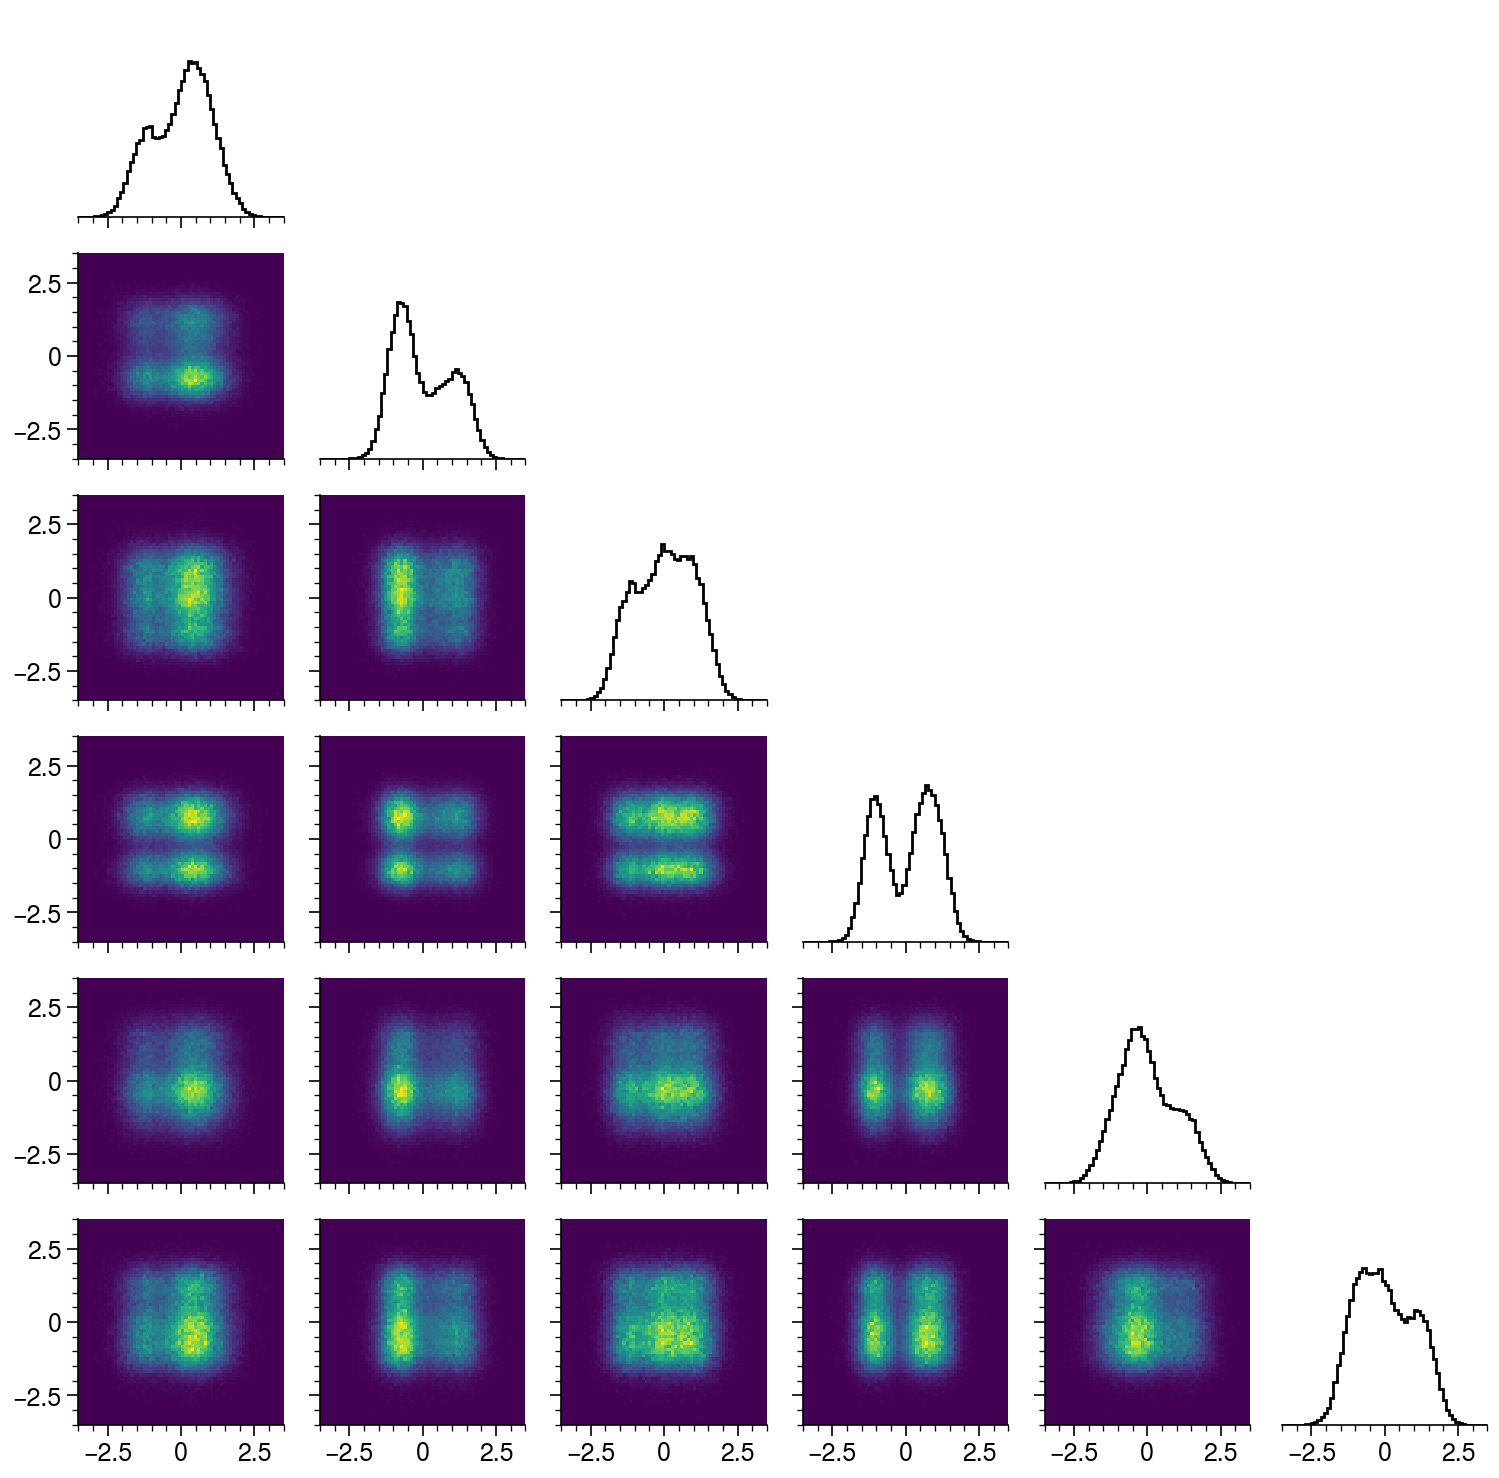

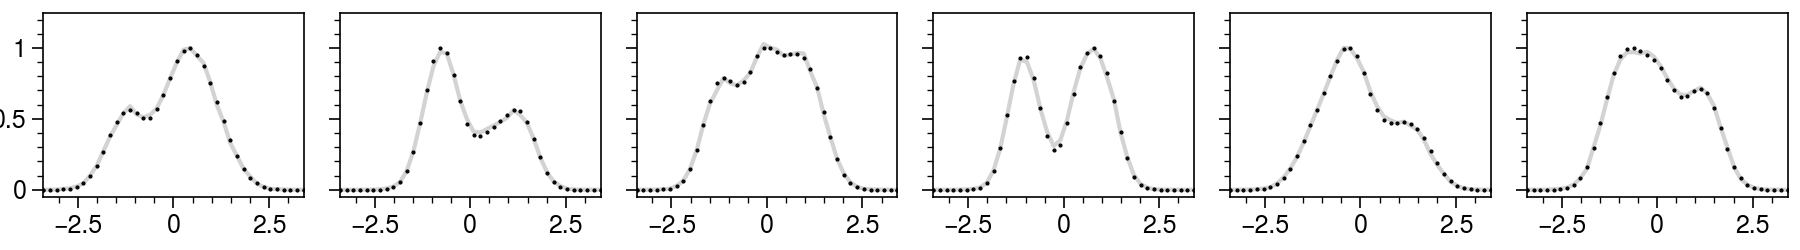

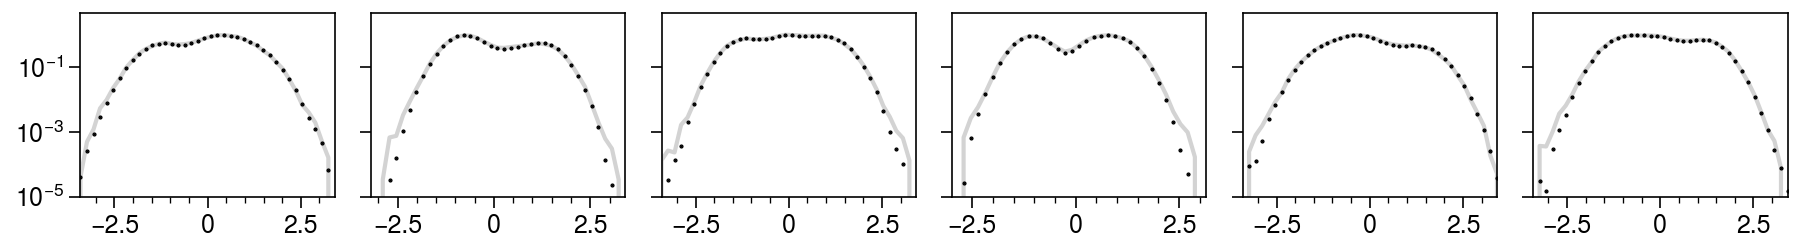

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 399/14031 [00:00<00:03, 3984.74it/s]

  6%|██████▎                                                                                                       | 804/14031 [00:00<00:03, 4018.77it/s]

  9%|█████████▍                                                                                                   | 1207/14031 [00:00<00:03, 4022.64it/s]

 12%|████████████▌                                                                                                | 1615/14031 [00:00<00:03, 4044.26it/s]

 14%|███████████████▋                                                                                             | 2024/14031 [00:00<00:02, 4057.68it/s]

 17%|██████████████████▉                                                                                          | 2432/14031 [00:00<00:02, 4064.93it/s]

 20%|██████████████████████                                                                                       | 2840/14031 [00:00<00:02, 4067.35it/s]

 23%|█████████████████████████▏                                                                                   | 3247/14031 [00:00<00:02, 4025.27it/s]

 26%|████████████████████████████▎                                                                                | 3650/14031 [00:00<00:02, 3988.63it/s]

 29%|███████████████████████████████▍                                                                             | 4049/14031 [00:01<00:02, 3933.53it/s]

 32%|██████████████████████████████████▌                                                                          | 4443/14031 [00:01<00:02, 3878.03it/s]

 34%|█████████████████████████████████████▌                                                                       | 4836/14031 [00:01<00:02, 3892.16it/s]

 37%|████████████████████████████████████████▌                                                                    | 5226/14031 [00:01<00:02, 3870.50it/s]

 40%|███████████████████████████████████████████▌                                                                 | 5614/14031 [00:01<00:02, 3864.77it/s]

 43%|██████████████████████████████████████████████▋                                                              | 6005/14031 [00:01<00:02, 3876.66it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 6394/14031 [00:01<00:01, 3877.98it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 6782/14031 [00:01<00:01, 3873.36it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 7177/14031 [00:01<00:01, 3892.88it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 7567/14031 [00:01<00:01, 3888.74it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 7956/14031 [00:02<00:01, 3878.35it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 8344/14031 [00:02<00:01, 3868.13it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 8745/14031 [00:02<00:01, 3909.30it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 9145/14031 [00:02<00:01, 3934.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 9548/14031 [00:02<00:01, 3962.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 9945/14031 [00:02<00:01, 3954.10it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 10341/14031 [00:02<00:00, 3944.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 10747/14031 [00:02<00:00, 3975.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 11156/14031 [00:02<00:00, 4008.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 11562/14031 [00:02<00:00, 4023.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 11969/14031 [00:03<00:00, 4037.21it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 12378/14031 [00:03<00:00, 4050.28it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 12784/14031 [00:03<00:00, 4037.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 13188/14031 [00:03<00:00, 4030.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 13592/14031 [00:03<00:00, 4032.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 13996/14031 [00:03<00:00, 4019.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3965.03it/s]

{'mean_abs_error': 0.003442156448459915}
epoch = 3
transform=0
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 399/12015 [00:00<00:02, 3989.73it/s]

  7%|███████▍                                                                                                      | 809/12015 [00:00<00:02, 4052.25it/s]

 10%|███████████                                                                                                  | 1217/12015 [00:00<00:02, 4063.77it/s]

 14%|██████████████▊                                                                                              | 1626/12015 [00:00<00:02, 4072.76it/s]

 17%|██████████████████▍                                                                                          | 2035/12015 [00:00<00:02, 4075.40it/s]

 20%|██████████████████████▏                                                                                      | 2445/12015 [00:00<00:02, 4080.61it/s]

 24%|█████████████████████████▉                                                                                   | 2855/12015 [00:00<00:02, 4086.27it/s]

 27%|█████████████████████████████▌                                                                               | 3264/12015 [00:00<00:02, 4087.06it/s]

 31%|█████████████████████████████████▎                                                                           | 3676/12015 [00:00<00:02, 4094.91it/s]

 34%|█████████████████████████████████████                                                                        | 4088/12015 [00:01<00:01, 4101.45it/s]

 37%|████████████████████████████████████████▊                                                                    | 4499/12015 [00:01<00:01, 4101.97it/s]

 41%|████████████████████████████████████████████▌                                                                | 4912/12015 [00:01<00:01, 4107.92it/s]

 44%|████████████████████████████████████████████████▎                                                            | 5324/12015 [00:01<00:01, 4108.62it/s]

 48%|████████████████████████████████████████████████████                                                         | 5735/12015 [00:01<00:01, 4106.75it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 6147/12015 [00:01<00:01, 4109.81it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 6560/12015 [00:01<00:01, 4114.53it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 6972/12015 [00:01<00:01, 4115.76it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 7384/12015 [00:01<00:01, 4112.84it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 7796/12015 [00:01<00:01, 4071.26it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 8207/12015 [00:02<00:00, 4081.17it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 8620/12015 [00:02<00:00, 4094.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 9031/12015 [00:02<00:00, 4098.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 9443/12015 [00:02<00:00, 4104.13it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 9856/12015 [00:02<00:00, 4108.99it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 10267/12015 [00:02<00:00, 4108.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 10680/12015 [00:02<00:00, 4113.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11092/12015 [00:02<00:00, 4111.31it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11504/12015 [00:02<00:00, 4110.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 11916/12015 [00:02<00:00, 4112.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4097.43it/s]

transform=1
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 409/12015 [00:00<00:02, 4086.93it/s]

  7%|███████▌                                                                                                      | 820/12015 [00:00<00:02, 4100.35it/s]

 10%|███████████▏                                                                                                 | 1231/12015 [00:00<00:02, 4100.04it/s]

 14%|██████████████▉                                                                                              | 1642/12015 [00:00<00:02, 4098.50it/s]

 17%|██████████████████▌                                                                                          | 2052/12015 [00:00<00:02, 4098.48it/s]

 20%|██████████████████████▎                                                                                      | 2462/12015 [00:00<00:02, 4096.19it/s]

 24%|██████████████████████████                                                                                   | 2872/12015 [00:00<00:02, 4095.03it/s]

 27%|█████████████████████████████▊                                                                               | 3286/12015 [00:00<00:02, 4106.30it/s]

 31%|█████████████████████████████████▌                                                                           | 3702/12015 [00:00<00:02, 4120.05it/s]

 34%|█████████████████████████████████████▎                                                                       | 4116/12015 [00:01<00:01, 4125.40it/s]

 38%|█████████████████████████████████████████                                                                    | 4530/12015 [00:01<00:01, 4129.21it/s]

 41%|████████████████████████████████████████████▊                                                                | 4945/12015 [00:01<00:01, 4135.36it/s]

 45%|████████████████████████████████████████████████▌                                                            | 5359/12015 [00:01<00:01, 4121.66it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5772/12015 [00:01<00:01, 4108.65it/s]

 51%|████████████████████████████████████████████████████████                                                     | 6183/12015 [00:01<00:01, 4075.03it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6595/12015 [00:01<00:01, 4088.21it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7009/12015 [00:01<00:01, 4101.60it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7423/12015 [00:01<00:01, 4111.58it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 7838/12015 [00:01<00:01, 4121.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8253/12015 [00:02<00:00, 4130.14it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 8668/12015 [00:02<00:00, 4134.37it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 9083/12015 [00:02<00:00, 4138.92it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 9498/12015 [00:02<00:00, 4139.89it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 9915/12015 [00:02<00:00, 4147.37it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 10330/12015 [00:02<00:00, 4141.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 10745/12015 [00:02<00:00, 4132.50it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11159/12015 [00:02<00:00, 4128.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 11572/12015 [00:02<00:00, 4127.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 11985/12015 [00:02<00:00, 4116.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4116.35it/s]

transform=2
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 405/12015 [00:00<00:02, 4042.16it/s]

  7%|███████▍                                                                                                      | 816/12015 [00:00<00:02, 4077.27it/s]

 10%|███████████▏                                                                                                 | 1229/12015 [00:00<00:02, 4097.21it/s]

 14%|██████████████▉                                                                                              | 1640/12015 [00:00<00:02, 4101.34it/s]

 17%|██████████████████▌                                                                                          | 2051/12015 [00:00<00:02, 4101.37it/s]

 20%|██████████████████████▎                                                                                      | 2462/12015 [00:00<00:02, 4099.81it/s]

 24%|██████████████████████████                                                                                   | 2874/12015 [00:00<00:02, 4105.10it/s]

 27%|█████████████████████████████▊                                                                               | 3285/12015 [00:00<00:02, 4098.93it/s]

 31%|█████████████████████████████████▌                                                                           | 3700/12015 [00:00<00:02, 4112.48it/s]

 34%|█████████████████████████████████████▎                                                                       | 4117/12015 [00:01<00:01, 4127.37it/s]

 38%|█████████████████████████████████████████                                                                    | 4533/12015 [00:01<00:01, 4135.88it/s]

 41%|████████████████████████████████████████████▉                                                                | 4947/12015 [00:01<00:01, 4127.90it/s]

 45%|████████████████████████████████████████████████▋                                                            | 5360/12015 [00:01<00:01, 4095.73it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5770/12015 [00:01<00:01, 4085.87it/s]

 51%|████████████████████████████████████████████████████████                                                     | 6182/12015 [00:01<00:01, 4094.52it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6594/12015 [00:01<00:01, 4099.23it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7005/12015 [00:01<00:01, 4102.22it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7417/12015 [00:01<00:01, 4106.76it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 7834/12015 [00:01<00:01, 4122.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8249/12015 [00:02<00:00, 4130.75it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 8663/12015 [00:02<00:00, 4120.75it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 9076/12015 [00:02<00:00, 4101.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 9487/12015 [00:02<00:00, 4096.07it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 9900/12015 [00:02<00:00, 4104.95it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 10313/12015 [00:02<00:00, 4111.44it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 10725/12015 [00:02<00:00, 4112.49it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 11138/12015 [00:02<00:00, 4116.94it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11550/12015 [00:02<00:00, 4116.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11963/12015 [00:02<00:00, 4120.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4108.05it/s]

transform=3
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▊                                                                                                          | 411/12015 [00:00<00:02, 4100.36it/s]

  7%|███████▌                                                                                                      | 824/12015 [00:00<00:02, 4114.95it/s]

 10%|███████████▏                                                                                                 | 1236/12015 [00:00<00:02, 4109.85it/s]

 14%|██████████████▉                                                                                              | 1650/12015 [00:00<00:02, 4120.97it/s]

 17%|██████████████████▋                                                                                          | 2063/12015 [00:00<00:02, 4115.71it/s]

 21%|██████████████████████▍                                                                                      | 2475/12015 [00:00<00:02, 4116.76it/s]

 24%|██████████████████████████▏                                                                                  | 2887/12015 [00:00<00:02, 4115.40it/s]

 27%|█████████████████████████████▉                                                                               | 3299/12015 [00:00<00:02, 4111.23it/s]

 31%|█████████████████████████████████▋                                                                           | 3711/12015 [00:00<00:02, 4107.38it/s]

 34%|█████████████████████████████████████▍                                                                       | 4122/12015 [00:01<00:01, 4071.17it/s]

 38%|█████████████████████████████████████████                                                                    | 4530/12015 [00:01<00:01, 4058.03it/s]

 41%|████████████████████████████████████████████▊                                                                | 4946/12015 [00:01<00:01, 4086.71it/s]

 45%|████████████████████████████████████████████████▋                                                            | 5361/12015 [00:01<00:01, 4105.71it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5773/12015 [00:01<00:01, 4108.52it/s]

 51%|████████████████████████████████████████████████████████                                                     | 6186/12015 [00:01<00:01, 4112.79it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6598/12015 [00:01<00:01, 4113.72it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7011/12015 [00:01<00:01, 4118.52it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7423/12015 [00:01<00:01, 4085.82it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 7832/12015 [00:01<00:01, 4055.08it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8240/12015 [00:02<00:00, 4060.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8649/12015 [00:02<00:00, 4069.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 9061/12015 [00:02<00:00, 4083.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 9472/12015 [00:02<00:00, 4089.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 9883/12015 [00:02<00:00, 4092.25it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 10293/12015 [00:02<00:00, 4035.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 10697/12015 [00:02<00:00, 4035.23it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11110/12015 [00:02<00:00, 4062.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11523/12015 [00:02<00:00, 4080.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11939/12015 [00:02<00:00, 4101.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4089.81it/s]

transform=4
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▋                                                                                                          | 401/12015 [00:00<00:02, 4000.08it/s]

  7%|███████▎                                                                                                      | 802/12015 [00:00<00:02, 3998.65it/s]

 10%|██████████▉                                                                                                  | 1202/12015 [00:00<00:02, 3982.80it/s]

 13%|██████████████▌                                                                                              | 1601/12015 [00:00<00:02, 3975.95it/s]

 17%|██████████████████▏                                                                                          | 1999/12015 [00:00<00:02, 3974.60it/s]

 20%|█████████████████████▊                                                                                       | 2406/12015 [00:00<00:02, 4002.98it/s]

 23%|█████████████████████████▍                                                                                   | 2807/12015 [00:00<00:02, 3998.96it/s]

 27%|█████████████████████████████▏                                                                               | 3211/12015 [00:00<00:02, 4010.73it/s]

 30%|████████████████████████████████▉                                                                            | 3624/12015 [00:00<00:02, 4047.11it/s]

 34%|████████████████████████████████████▋                                                                        | 4040/12015 [00:01<00:01, 4079.67it/s]

 37%|████████████████████████████████████████▎                                                                    | 4450/12015 [00:01<00:01, 4083.21it/s]

 40%|████████████████████████████████████████████                                                                 | 4860/12015 [00:01<00:01, 4086.39it/s]

 44%|███████████████████████████████████████████████▊                                                             | 5273/12015 [00:01<00:01, 4097.97it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 5688/12015 [00:01<00:01, 4111.71it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 6100/12015 [00:01<00:01, 4067.04it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 6512/12015 [00:01<00:01, 4080.43it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 6921/12015 [00:01<00:01, 4064.69it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 7334/12015 [00:01<00:01, 4082.97it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 7751/12015 [00:01<00:01, 4106.29it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 8164/12015 [00:02<00:00, 4110.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 8578/12015 [00:02<00:00, 4118.71it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 8990/12015 [00:02<00:00, 4102.02it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 9401/12015 [00:02<00:00, 4085.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 9816/12015 [00:02<00:00, 4102.42it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 10231/12015 [00:02<00:00, 4116.36it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 10647/12015 [00:02<00:00, 4128.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 11064/12015 [00:02<00:00, 4138.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 11479/12015 [00:02<00:00, 4141.60it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 11897/12015 [00:02<00:00, 4152.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4083.18it/s]

transform=5
diagnostic=0


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  3%|███▊                                                                                                          | 413/12015 [00:00<00:02, 4123.25it/s]

  7%|███████▌                                                                                                      | 829/12015 [00:00<00:02, 4140.57it/s]

 10%|███████████▎                                                                                                 | 1245/12015 [00:00<00:02, 4146.42it/s]

 14%|███████████████                                                                                              | 1660/12015 [00:00<00:02, 4056.61it/s]

 17%|██████████████████▊                                                                                          | 2074/12015 [00:00<00:02, 4083.55it/s]

 21%|██████████████████████▌                                                                                      | 2483/12015 [00:00<00:02, 4080.64it/s]

 24%|██████████████████████████▎                                                                                  | 2900/12015 [00:00<00:02, 4107.04it/s]

 28%|██████████████████████████████                                                                               | 3317/12015 [00:00<00:02, 4124.88it/s]

 31%|█████████████████████████████████▊                                                                           | 3730/12015 [00:00<00:02, 4114.76it/s]

 35%|█████████████████████████████████████▌                                                                       | 4146/12015 [00:01<00:01, 4126.40it/s]

 38%|█████████████████████████████████████████▍                                                                   | 4561/12015 [00:01<00:01, 4130.70it/s]

 41%|█████████████████████████████████████████████▏                                                               | 4975/12015 [00:01<00:01, 4075.65it/s]

 45%|████████████████████████████████████████████████▊                                                            | 5383/12015 [00:01<00:01, 4046.52it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 5792/12015 [00:01<00:01, 4056.96it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 6205/12015 [00:01<00:01, 4077.50it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 6613/12015 [00:01<00:01, 3974.37it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7024/12015 [00:01<00:01, 4013.21it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 7433/12015 [00:01<00:01, 4033.28it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 7844/12015 [00:01<00:01, 4054.08it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 8255/12015 [00:02<00:00, 4070.20it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 8670/12015 [00:02<00:00, 4092.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                          | 9080/12015 [00:02<00:00, 4025.37it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 9483/12015 [00:02<00:00, 3956.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 9886/12015 [00:02<00:00, 3975.26it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 10297/12015 [00:02<00:00, 4013.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 10710/12015 [00:02<00:00, 4045.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 11125/12015 [00:02<00:00, 4076.09it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 11541/12015 [00:02<00:00, 4099.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 11956/12015 [00:02<00:00, 4113.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:02<00:00, 4068.84it/s]

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███                                                                                                           | 395/14031 [00:00<00:03, 3941.10it/s]

  6%|██████▏                                                                                                       | 790/14031 [00:00<00:03, 3899.58it/s]

  8%|█████████▏                                                                                                   | 1180/14031 [00:00<00:03, 3639.79it/s]

 11%|████████████▎                                                                                                | 1577/14031 [00:00<00:03, 3761.79it/s]

 14%|███████████████▎                                                                                             | 1969/14031 [00:00<00:03, 3814.38it/s]

 17%|██████████████████▎                                                                                          | 2365/14031 [00:00<00:03, 3860.11it/s]

 20%|█████████████████████▍                                                                                       | 2763/14031 [00:00<00:02, 3897.76it/s]

 22%|████████████████████████▌                                                                                    | 3155/14031 [00:00<00:02, 3903.22it/s]

 25%|███████████████████████████▌                                                                                 | 3546/14031 [00:00<00:02, 3888.34it/s]

 28%|██████████████████████████████▋                                                                              | 3943/14031 [00:01<00:02, 3911.83it/s]

 31%|█████████████████████████████████▋                                                                           | 4335/14031 [00:01<00:02, 3907.34it/s]

 34%|████████████████████████████████████▋                                                                        | 4726/14031 [00:01<00:02, 3897.38it/s]

 36%|███████████████████████████████████████▋                                                                     | 5116/14031 [00:01<00:02, 3859.75it/s]

 39%|██████████████████████████████████████████▊                                                                  | 5515/14031 [00:01<00:02, 3896.35it/s]

 42%|█████████████████████████████████████████████▉                                                               | 5907/14031 [00:01<00:02, 3902.63it/s]

 45%|█████████████████████████████████████████████████                                                            | 6314/14031 [00:01<00:01, 3951.07it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 6723/14031 [00:01<00:01, 3990.10it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 7134/14031 [00:01<00:01, 4023.28it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 7545/14031 [00:01<00:01, 4047.46it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 7961/14031 [00:02<00:01, 4080.52it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 8376/14031 [00:02<00:01, 4101.20it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                        | 8787/14031 [00:02<00:01, 4083.80it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 9204/14031 [00:02<00:01, 4107.78it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 9622/14031 [00:02<00:01, 4128.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 10041/14031 [00:02<00:00, 4144.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 10458/14031 [00:02<00:00, 4150.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                        | 10875/14031 [00:02<00:00, 4155.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 11295/14031 [00:02<00:00, 4166.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 11713/14031 [00:02<00:00, 4169.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 12131/14031 [00:03<00:00, 4171.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 12550/14031 [00:03<00:00, 4174.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 12968/14031 [00:03<00:00, 4174.01it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 13386/14031 [00:03<00:00, 4175.20it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 13804/14031 [00:03<00:00, 4169.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4025.95it/s]

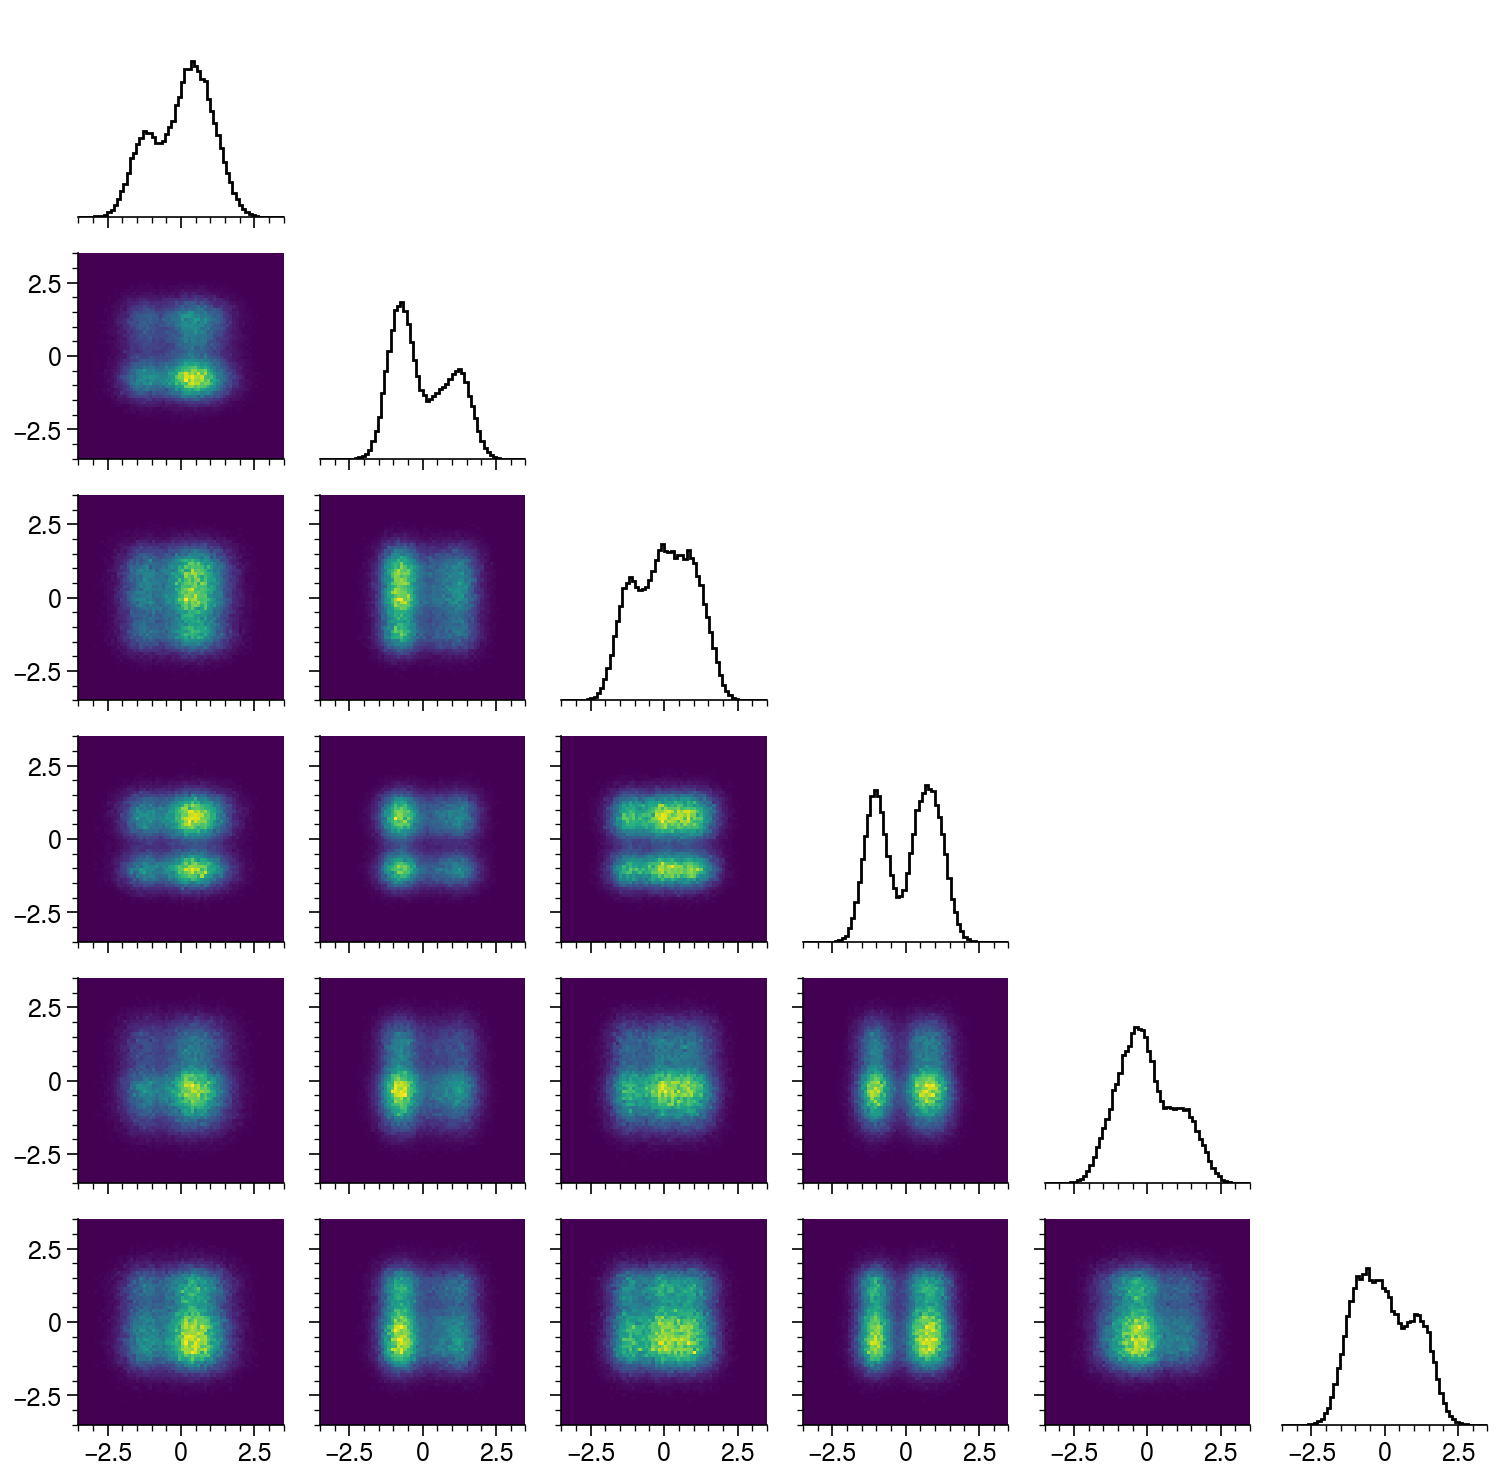

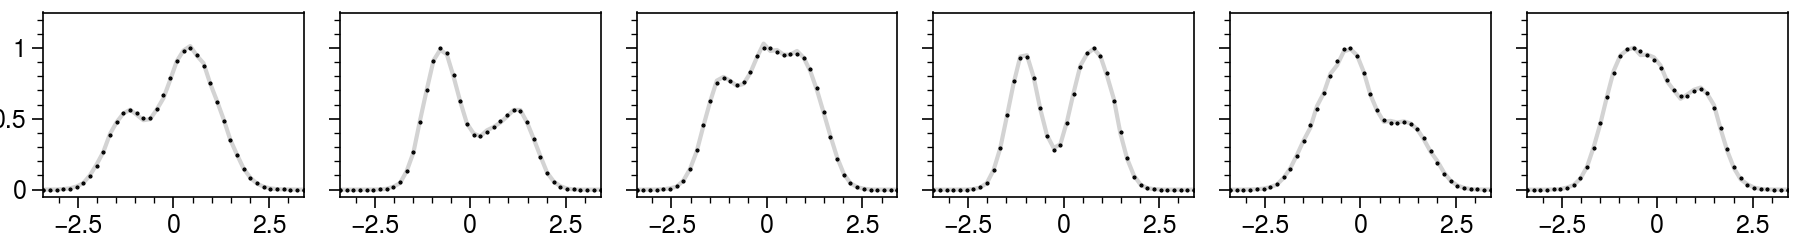

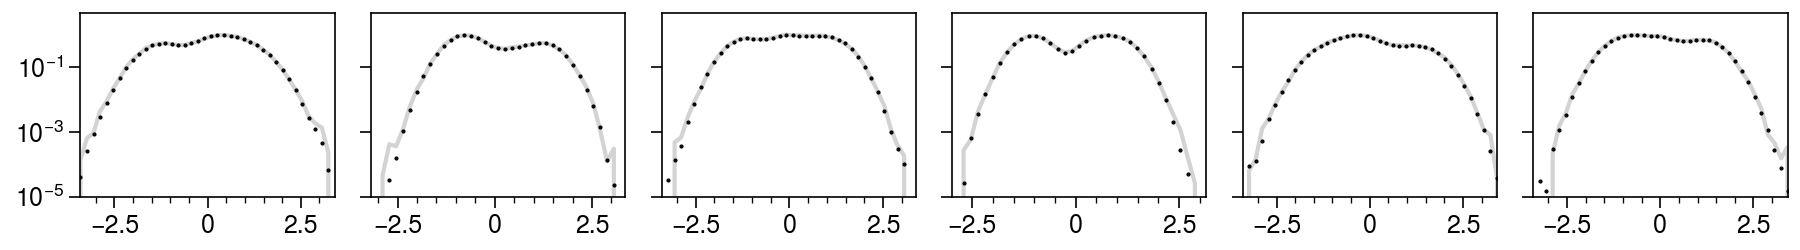

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███                                                                                                           | 386/14031 [00:00<00:03, 3857.84it/s]

  6%|██████                                                                                                        | 778/14031 [00:00<00:03, 3891.47it/s]

  8%|█████████                                                                                                    | 1168/14031 [00:00<00:03, 3828.89it/s]

 11%|████████████                                                                                                 | 1558/14031 [00:00<00:03, 3854.33it/s]

 14%|███████████████                                                                                              | 1944/14031 [00:00<00:03, 3856.18it/s]

 17%|██████████████████▏                                                                                          | 2334/14031 [00:00<00:03, 3870.71it/s]

 19%|█████████████████████▏                                                                                       | 2722/14031 [00:00<00:02, 3858.97it/s]

 22%|████████████████████████▏                                                                                    | 3117/14031 [00:00<00:02, 3884.54it/s]

 25%|███████████████████████████▎                                                                                 | 3508/14031 [00:00<00:02, 3891.86it/s]

 28%|██████████████████████████████▎                                                                              | 3898/14031 [00:01<00:02, 3724.43it/s]

 30%|█████████████████████████████████▏                                                                           | 4272/14031 [00:01<00:02, 3423.89it/s]

 33%|████████████████████████████████████                                                                         | 4648/14031 [00:01<00:02, 3517.55it/s]

 36%|███████████████████████████████████████                                                                      | 5031/14031 [00:01<00:02, 3605.67it/s]

 39%|██████████████████████████████████████████▏                                                                  | 5430/14031 [00:01<00:02, 3715.37it/s]

 41%|█████████████████████████████████████████████▏                                                               | 5819/14031 [00:01<00:02, 3764.49it/s]

 44%|████████████████████████████████████████████████▎                                                            | 6211/14031 [00:01<00:02, 3809.47it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 6607/14031 [00:01<00:01, 3852.35it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 7022/14031 [00:01<00:01, 3939.92it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 7437/14031 [00:01<00:01, 4001.02it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 7838/14031 [00:02<00:01, 3991.00it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 8238/14031 [00:02<00:01, 3877.78it/s]

 61%|███████████████████████████████████████████████████████████████████                                          | 8627/14031 [00:02<00:01, 3850.97it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 9013/14031 [00:02<00:01, 3828.40it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 9405/14031 [00:02<00:01, 3854.63it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 9798/14031 [00:02<00:01, 3874.93it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 10186/14031 [00:02<00:00, 3846.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 10571/14031 [00:02<00:00, 3810.61it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 10962/14031 [00:02<00:00, 3838.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 11359/14031 [00:02<00:00, 3875.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 11747/14031 [00:03<00:00, 3859.41it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 12136/14031 [00:03<00:00, 3867.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 12528/14031 [00:03<00:00, 3881.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 12925/14031 [00:03<00:00, 3905.51it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 13317/14031 [00:03<00:00, 3907.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 13708/14031 [00:03<00:00, 3900.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3834.12it/s]

{'mean_abs_error': 0.002297627912555812}


In [11]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=eval_model,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)

## Evaluate

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  3%|███▏                                                                                                          | 414/14031 [00:00<00:03, 4130.05it/s]

  6%|██████▍                                                                                                       | 829/14031 [00:00<00:03, 4136.84it/s]

  9%|█████████▋                                                                                                   | 1243/14031 [00:00<00:03, 4108.56it/s]

 12%|████████████▊                                                                                                | 1656/14031 [00:00<00:03, 4114.28it/s]

 15%|████████████████                                                                                             | 2071/14031 [00:00<00:02, 4124.91it/s]

 18%|███████████████████▎                                                                                         | 2484/14031 [00:00<00:02, 4115.29it/s]

 21%|██████████████████████▌                                                                                      | 2897/14031 [00:00<00:02, 4118.84it/s]

 24%|█████████████████████████▋                                                                                   | 3313/14031 [00:00<00:02, 4130.19it/s]

 27%|████████████████████████████▉                                                                                | 3727/14031 [00:00<00:02, 4129.68it/s]

 30%|████████████████████████████████▏                                                                            | 4140/14031 [00:01<00:02, 4074.62it/s]

 32%|███████████████████████████████████▎                                                                         | 4548/14031 [00:01<00:02, 4012.33it/s]

 35%|██████████████████████████████████████▌                                                                      | 4957/14031 [00:01<00:02, 4035.10it/s]

 38%|█████████████████████████████████████████▋                                                                   | 5366/14031 [00:01<00:02, 4051.08it/s]

 41%|████████████████████████████████████████████▊                                                                | 5776/14031 [00:01<00:02, 4063.37it/s]

 44%|████████████████████████████████████████████████                                                             | 6187/14031 [00:01<00:01, 4075.86it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 6599/14031 [00:01<00:01, 4086.41it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 7008/14031 [00:01<00:01, 4081.97it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 7421/14031 [00:01<00:01, 4093.86it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 7834/14031 [00:01<00:01, 4102.83it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 8248/14031 [00:02<00:01, 4111.16it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 8660/14031 [00:02<00:01, 4092.61it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 9075/14031 [00:02<00:01, 4108.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 9490/14031 [00:02<00:01, 4118.60it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 9905/14031 [00:02<00:01, 4125.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 10318/14031 [00:02<00:00, 4117.62it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 10732/14031 [00:02<00:00, 4122.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 11145/14031 [00:02<00:00, 4115.96it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 11557/14031 [00:02<00:00, 4096.23it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 11973/14031 [00:02<00:00, 4114.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 12389/14031 [00:03<00:00, 4127.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 12802/14031 [00:03<00:00, 4107.99it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 13213/14031 [00:03<00:00, 4042.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 13618/14031 [00:03<00:00, 4035.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4092.55it/s]

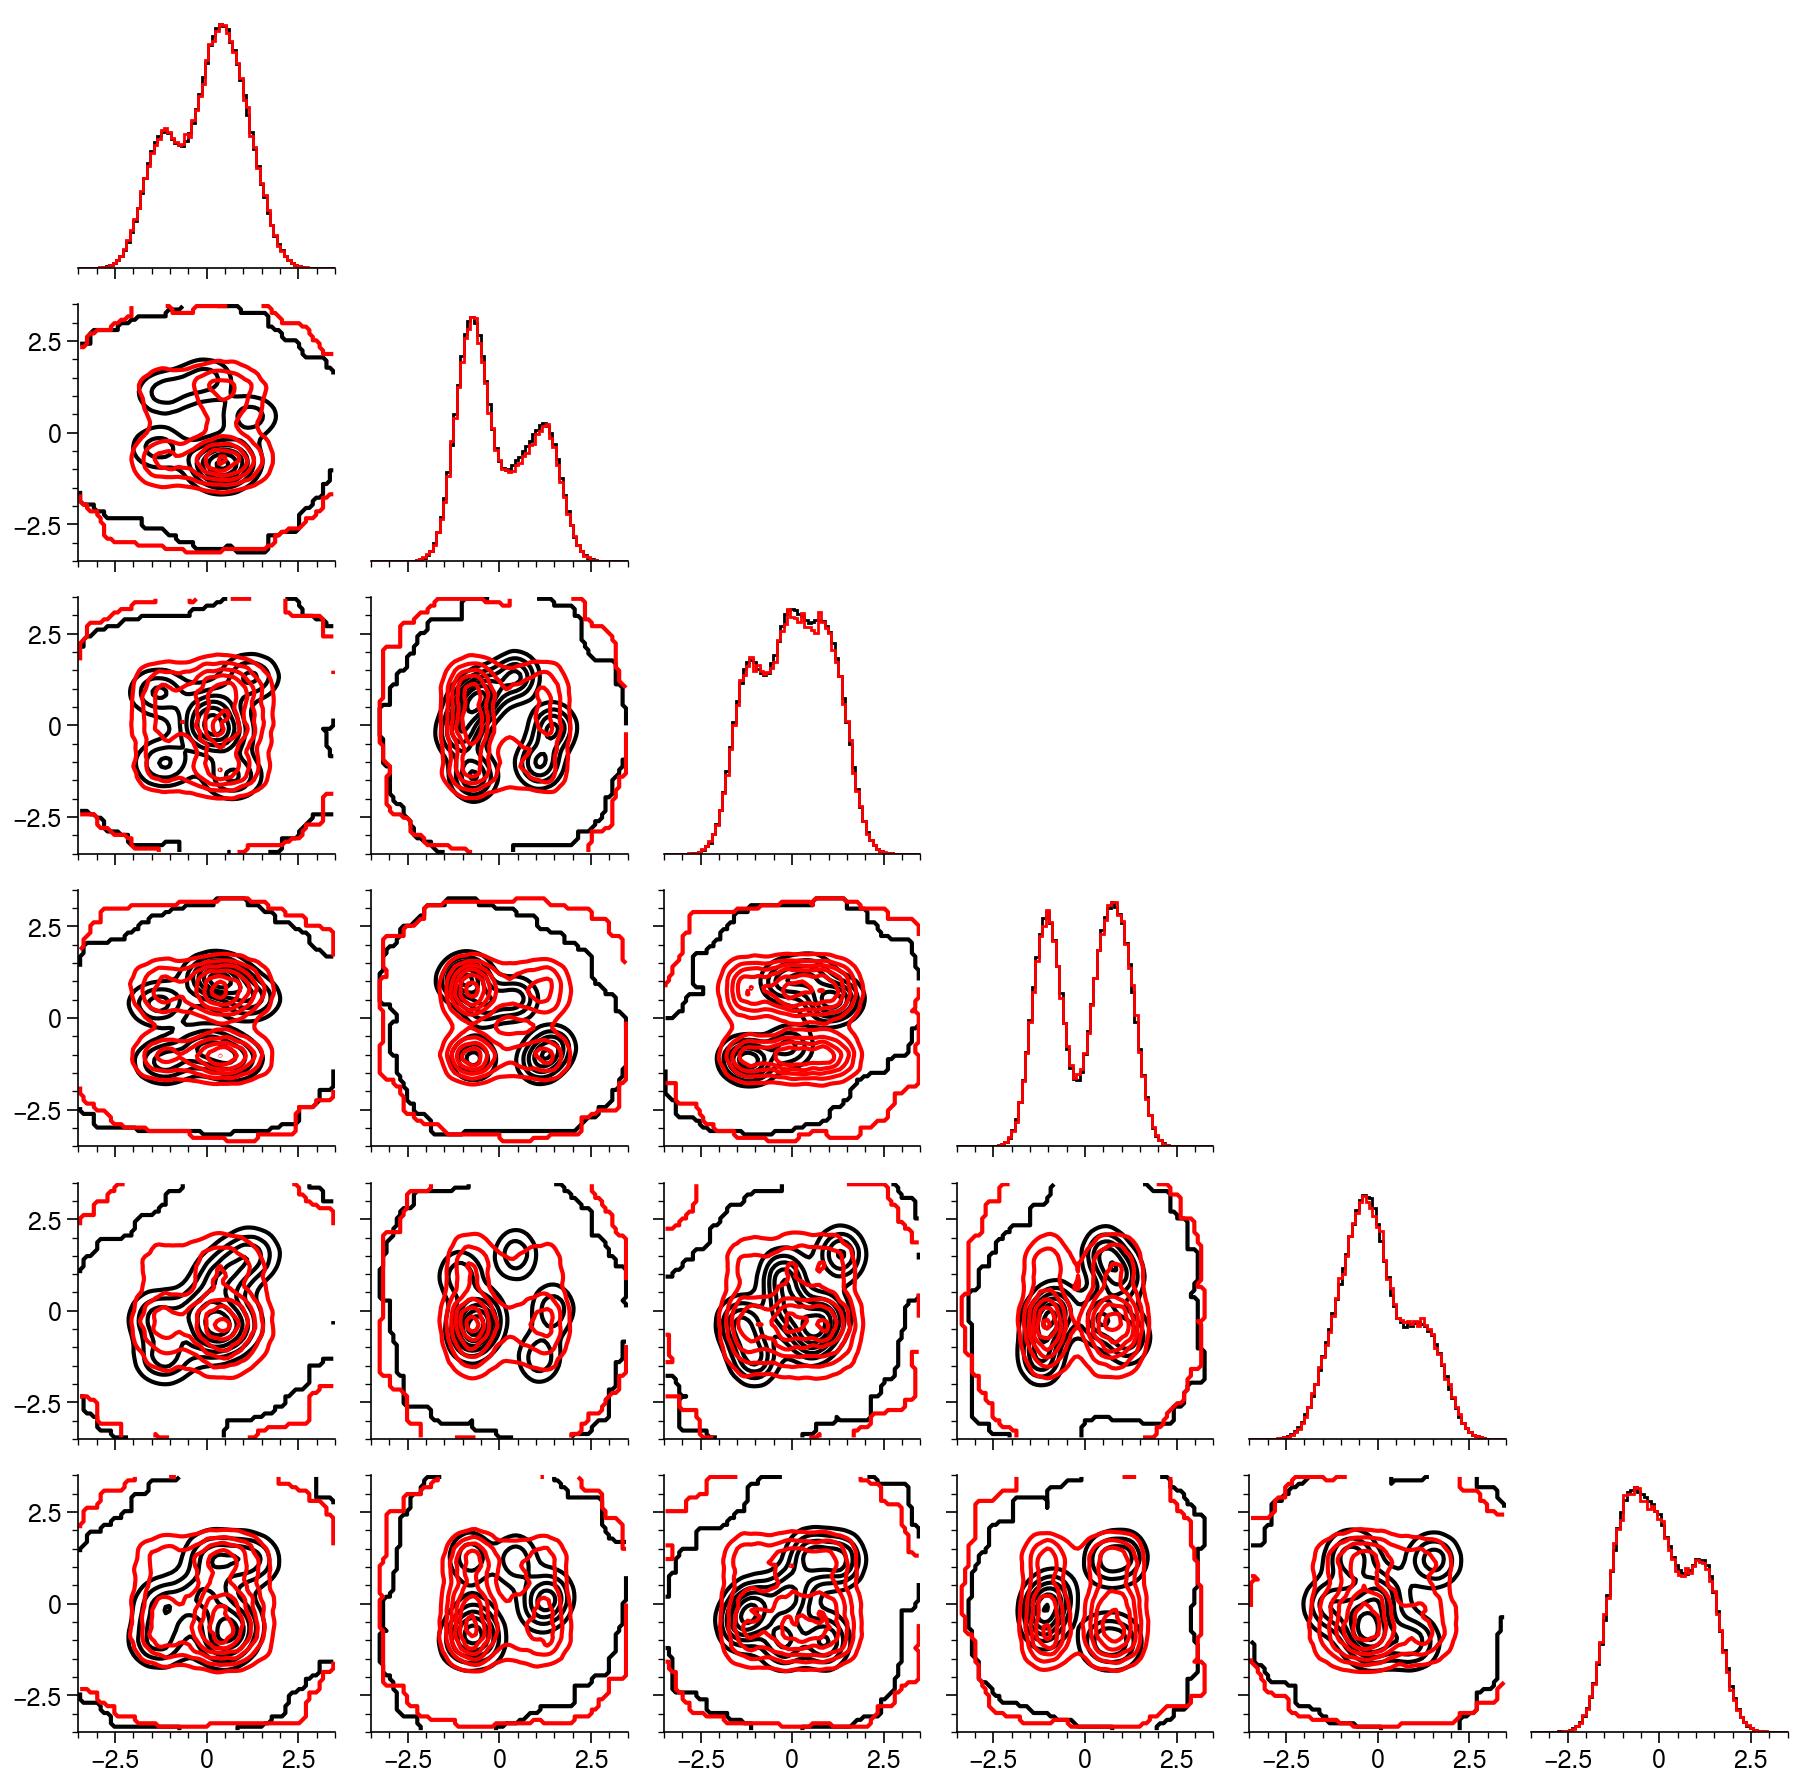

In [12]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()